<a href="https://colab.research.google.com/github/immischein/ML-bandgap/blob/main/model_building_nikodemas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing Packages

In [ ]:
!pip install category_encoders

# Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

import shap
import category_encoders as ce
import time


/Users/nikodemas/Desktop/University_of_amsterdam/Academics/AMEP/2025_spring_p2/Machine_Learning/project/matgen-env-new/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



# Data Imports and Processing


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# import sys
# sys.path.append('/content/drive/MyDrive/ColabImports')

# Load the CSV file (update the path to match your local filesystem)
df = pd.read_csv('INSERT YOUR PATH HERE')  # e.g., './data/bandgap_dataset_premium.csv'

# Quick check
print(df.head())

  material_id  band_gap  formula   density       volume          a          b  \
0    mp-11107    3.5226    Ac2O3  9.109130    91.511224   4.095487   4.095489   
1    mp-32800    2.2962    Ac2S3  6.535149  1118.407852  14.997851  14.997851   
2   mp-977351    3.0275    Ac2S3  5.562971   328.464893   7.619779   7.619773   
3   mp-867311    0.0794  AcAgTe2  7.997421   122.518406   5.574922   5.574922   
4  mp-1183115    4.1024   AcAlO3  8.728230    57.451413   3.858634   3.858634   

           c       alpha        beta  ...      std_am  avg_vdw  vdw_range  \
0   6.299882   90.000000   90.000000  ...  103.368761    1.900       0.95   
1  14.997851  144.742139  144.742139  ...   95.498257    2.068       0.67   
2   7.875664  118.930903   61.069136  ...   95.498257    2.068       0.67   
3   5.574922   60.000000   60.000000  ...   46.591170    2.175       0.41   
4   3.858634   90.000000   90.000000  ...   83.410543    1.774       0.95   

   max_vdw  min_vdw   std_vdw     vbm      cbm  \


In [ ]:
df.head()

,material_id,band_gap,formula,density,volume,a,b,c,alpha,beta,...,std_am,avg_vdw,vdw_range,max_vdw,min_vdw,std_vdw,vbm,cbm,bulk_modulus,shear_modulus
0,mp-11107,3.5226,Ac2O3,9.109130,91.511224,4.095487,4.095489,6.299882,90.000000,90.000000,...,103.368761,1.900,0.95,2.47,1.52,0.465403,4.5896,8.1122,"{'voigt': 106.531, 'reuss': 96.061, 'vrh': 101...","{'voigt': 42.704, 'reuss': 28.813, 'vrh': 35.758}"
1,mp-32800,2.2962,Ac2S3,6.535149,1118.407852,14.997851,14.997851,14.997851,144.742139,144.742139,...,95.498257,2.068,0.67,2.47,1.80,0.328232,4.8014,7.0976,NaN,NaN
2,mp-977351,3.0275,Ac2S3,5.562971,328.464893,7.619779,7.619773,7.875664,118.930903,61.069136,...,95.498257,2.068,0.67,2.47,1.80,0.328232,2.9069,5.9344,NaN,NaN
3,mp-867311,0.0794,AcAgTe2,7.997421,122.518406,5.574922,5.574922,5.574922,60.000000,60.000000,...,46.591170,2.175,0.41,2.47,2.06,0.171537,5.9961,6.0755,NaN,NaN
4,mp-1183115,4.1024,AcAlO3,8.728230,57.451413,3.858634,3.858634,3.858634,90.000000,90.000000,...,83.410543,1.774,0.95,2.47,1.52,0.369410,6.8036,10.9060,NaN,NaN


In [ ]:
# To test script: load dummy data

#from sklearn.datasets import fetch_openml

# Load a regression dataset from OpenML
#data = fetch_openml(name="house_prices", as_frame=True)  # Ames housing data
#df = data.frame

# Rename target to match our script
#df = df.rename(columns={"SalePrice": "band_gap"})

In [ ]:
df.head()

,material_id,band_gap,formula,density,volume,a,b,c,alpha,beta,...,std_am,avg_vdw,vdw_range,max_vdw,min_vdw,std_vdw,vbm,cbm,bulk_modulus,shear_modulus
0,mp-11107,3.5226,Ac2O3,9.109130,91.511224,4.095487,4.095489,6.299882,90.000000,90.000000,...,103.368761,1.900,0.95,2.47,1.52,0.465403,4.5896,8.1122,"{'voigt': 106.531, 'reuss': 96.061, 'vrh': 101...","{'voigt': 42.704, 'reuss': 28.813, 'vrh': 35.758}"
1,mp-32800,2.2962,Ac2S3,6.535149,1118.407852,14.997851,14.997851,14.997851,144.742139,144.742139,...,95.498257,2.068,0.67,2.47,1.80,0.328232,4.8014,7.0976,NaN,NaN
2,mp-977351,3.0275,Ac2S3,5.562971,328.464893,7.619779,7.619773,7.875664,118.930903,61.069136,...,95.498257,2.068,0.67,2.47,1.80,0.328232,2.9069,5.9344,NaN,NaN
3,mp-867311,0.0794,AcAgTe2,7.997421,122.518406,5.574922,5.574922,5.574922,60.000000,60.000000,...,46.591170,2.175,0.41,2.47,2.06,0.171537,5.9961,6.0755,NaN,NaN
4,mp-1183115,4.1024,AcAlO3,8.728230,57.451413,3.858634,3.858634,3.858634,90.000000,90.000000,...,83.410543,1.774,0.95,2.47,1.52,0.369410,6.8036,10.9060,NaN,NaN


In [ ]:
# Data inspection

print("Data shape:", df.shape)

missing = df.isnull().sum()
missing = missing[missing > 0]
print("Missing values per column:")
for col, n in missing.items():
    print(f"{col}: {n}")

display(df.describe())

Data shape: (82998, 40)
Missing values per column:
formula: 1
avg_en: 9
max_en: 9
min_en: 9
std_en: 9
vbm: 876
cbm: 876
bulk_modulus: 79092
shear_modulus: 79092


,band_gap,density,volume,a,b,c,alpha,beta,gamma,n_atoms,...,max_am,min_am,std_am,avg_vdw,vdw_range,max_vdw,min_vdw,std_vdw,vbm,cbm
count,82998.000000,82998.000000,82998.000000,82998.000000,82998.000000,82998.000000,82998.000000,82998.000000,82998.000000,82998.000000,...,82998.000000,82998.000000,82998.000000,82998.000000,82998.000000,82998.000000,82998.000000,82998.000000,82122.000000,82122.000000
mean,1.984421,4.061805,668.913474,7.669236,8.044636,11.280915,86.028830,88.065828,89.700249,42.406058,...,110.699981,17.901714,31.772083,1.769480,0.787753,2.316020,1.528267,0.290510,1.585835,3.591381
std,1.560981,1.717274,693.624420,3.177138,2.800604,6.822619,17.420383,15.977789,22.074143,40.632079,...,57.428377,18.988597,20.400828,0.193034,0.380579,0.355453,0.203977,0.132925,2.238984,2.214685
min,0.000000,0.020144,11.286588,2.363000,2.363000,2.395898,3.664087,5.397478,5.397478,1.000000,...,1.007940,1.007940,0.000000,1.100000,0.000000,1.100000,1.100000,0.000000,-14.222600,-7.360600
25%,0.653400,2.913572,254.760639,5.553544,6.015389,7.389807,77.756958,88.952439,86.976837,16.000000,...,55.845000,6.941000,15.265807,1.666000,0.540000,2.070000,1.520000,0.207338,0.166850,2.368150
50%,1.728450,3.773981,452.574159,7.012094,7.718989,9.712402,90.000000,90.000000,90.000000,29.000000,...,106.420000,15.999400,26.508649,1.729333,0.720000,2.230000,1.520000,0.267822,1.629350,3.660450
75%,3.013225,4.954535,841.664286,8.965331,9.328646,13.157808,90.000000,90.000000,99.717832,54.000000,...,151.964000,15.999400,45.960918,1.855000,0.970000,2.430000,1.520000,0.348872,2.952475,4.974900
max,17.891400,18.889325,20090.906408,46.210701,61.125585,211.425839,169.783994,169.783994,168.048246,444.000000,...,244.000000,227.000000,107.897541,3.430000,2.330000,3.430000,3.430000,1.165000,12.376100,14.341400


In [ ]:
# Drop columns that are prohibited

df = df.drop(columns='vbm')
df = df.drop(columns='cbm')
df = df.drop(columns='formula')
df = df.drop(columns='material_id')

# Band Gap Range

In [ ]:
# Specify your band gap values
# df_subset = df[(df['band_gap'] >= 0.001) & (df['band_gap'] <= 5)]
min_band_gap = 0.001
max_band_gap = 50
df_subset = df[(df['band_gap'] >= min_band_gap) & (df['band_gap'] <= max_band_gap)]
display(df_subset.describe())

,band_gap,density,volume,a,b,c,alpha,beta,gamma,n_atoms,...,std_ie,avg_am,max_am,min_am,std_am,avg_vdw,vdw_range,max_vdw,min_vdw,std_vdw
count,81998.000000,81998.000000,81998.000000,81998.000000,81998.000000,81998.000000,81998.000000,81998.000000,81998.000000,81998.000000,...,81998.000000,81998.000000,81998.000000,81998.000000,81998.000000,81998.000000,81998.000000,81998.000000,81998.000000,81998.000000
mean,2.008621,4.033431,672.461985,7.684102,8.062514,11.301802,86.022149,88.083887,89.751261,42.681004,...,3.015456,41.806994,110.408409,17.531845,31.728694,1.767303,0.792940,2.317925,1.524985,0.292209
std,1.554917,1.674945,694.552196,3.176485,2.790923,6.802653,17.335792,15.883331,22.025312,40.714649,...,1.026880,27.205139,57.213171,18.062631,20.351142,0.191568,0.379161,0.356644,0.200925,0.132420
min,0.001000,0.020144,11.286588,2.363000,2.363000,2.395898,5.200300,5.397478,5.397478,1.000000,...,0.000000,1.007940,1.007940,1.007940,0.000000,1.100000,0.000000,1.100000,1.100000,0.000000
25%,0.688100,2.909166,257.364387,5.564078,6.028705,7.420564,77.817055,88.983131,87.252454,16.000000,...,2.416645,22.943680,55.845000,6.941000,15.278718,1.665500,0.540000,2.070000,1.520000,0.209335
50%,1.754650,3.756501,456.001697,7.028730,7.739968,9.731572,90.000000,90.000000,90.000000,30.000000,...,3.116394,31.789136,102.905500,15.999400,26.416604,1.728373,0.750000,2.230000,1.520000,0.268755
75%,3.031600,4.921850,845.734409,8.975985,9.344012,13.179710,90.000000,90.000000,99.687205,54.000000,...,3.607667,52.994662,150.360000,15.999400,45.925766,1.851395,0.970000,2.430000,1.520000,0.350143
max,17.891400,16.321559,20090.906408,46.210701,56.617301,211.425839,169.783994,169.783994,168.048246,444.000000,...,6.764457,218.862254,244.000000,208.980400,107.897541,3.430000,2.330000,3.430000,3.430000,1.165000


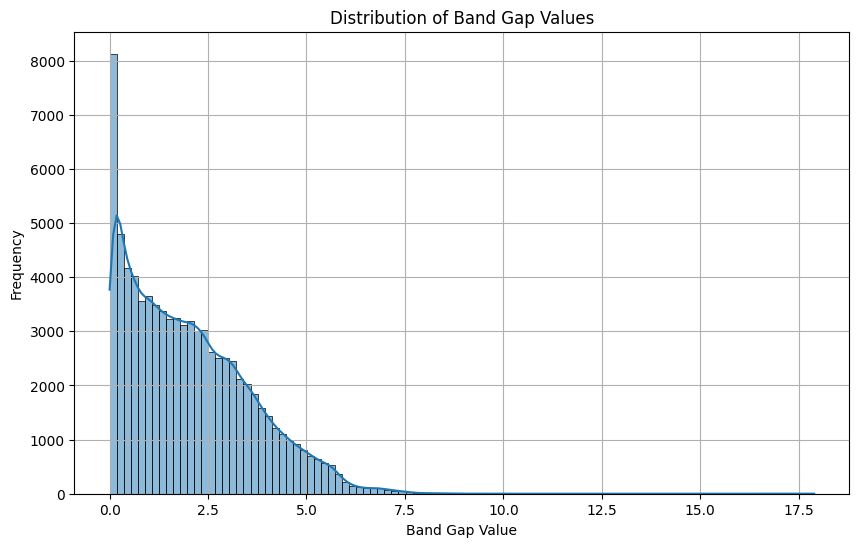

In [ ]:
# Make a plot of band gap values based on occurences
plt.figure(figsize=(10, 6))
sns.histplot(df_subset['band_gap'], bins=100, kde=True)
plt.title('Distribution of Band Gap Values')
plt.xlabel('Band Gap Value')
plt.ylabel('Frequency')
plt.grid()
plt.show()

# Define features and target

In [ ]:
target_column = "band_gap"
X = df_subset.drop(columns=[target_column])
y = df_subset[target_column]

# Seperate numeric and categorical columns

numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

# Preprocessing

In [ ]:
# To decide: drop columns with >65% missing values (can be lower, based on this dummy dataset)

threshold = 0.65
missing_frac = df_subset.isnull().mean()
cols_to_drop = missing_frac[missing_frac > threshold].index

print(f"Dropping columns with >{int(threshold*100)}% missing values:")
print(list(cols_to_drop))

df_subset = df_subset.drop(columns=cols_to_drop)

# To decide: impute missing numerical values with mean, categorical features with most frequent value
# StandardScaler subtracts mean and divides by std
# Use onehotencoder for categorical features


# Split into train and test sets BEFORE preprocessing
X = df_subset.drop("band_gap", axis=1)   # Replace "target" with your actual target column name
y = df_subset["band_gap"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply Target Encoding on training set only
# Convert a meaningufl categorical feature into a numerical one. This is more dense that one-hot encoding
# Transform a categorical variable into a numerical one using the mean of the target variable for each category
te_col = "spacegroup_number "
te_encoder = ce.TargetEncoder(cols=[te_col])
# apply target encoding on training set
X_train[te_col] = te_encoder.fit_transform(X_train[te_col], y_train)

# apply target encoding on test set
X_test[te_col] = te_encoder.transform(X_test[te_col])


# Proceed with rest of pre-processing pipeline
# Separate numeric and categorical columns again after dropping columns
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

# Numeric features are imputed with the mean and then scaled
numeric_transformer = make_pipeline(
    SimpleImputer(strategy="mean"), # fill missing values with mean
    StandardScaler()
)
# Categorical features are imputed with the most frequent value and then one-hot encoded
categorical_transformer = make_pipeline(
    SimpleImputer(strategy="most_frequent"), # fill missing values with most frequent value
    OneHotEncoder(handle_unknown="ignore") # one-hot encode categorical features
)

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols)
    ]
)

# Fit and transform the training data, and transform the test data
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

Dropping columns with >65% missing values:
['bulk_modulus', 'shear_modulus']


# Define the models to compare

In [ ]:
models = {
    "Dummy": DummyRegressor(),
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0), # Alpha is the regularization strength which penalizes large coefficients
    # Polynomaial regression with Ridge regularization (captures cubic relationships and ridge handles overfitting)
    # "Polynomial Regression": make_pipeline(
    #     PolynomialFeatures(degree=3, include_bias=False),
    #     StandardScaler(),
    #     Ridge(alpha=1.0)
    # ),
    # "Ridge": RidgeCV(alphas=[0.1, 1.0, 10.0], cv=5),
    "Gradient Boosting": GradientBoostingRegressor(
        n_estimators=100, # number of trees
        learning_rate=0.1, # step size shrinkage
        max_depth=3, # maximum depth of the individual trees
        random_state=42 # for reproducibility
    ),
    # #
    "XGBoost": XGBRegressor(
        n_estimators=100, # number of trees
        learning_rate=0.1, # step size shrinkage
        max_depth=3,
        random_state=42,
        n_jobs=-1 # use all available cores
    ),
    # Hist Gradient Boosting with hyperparameters
    "Hist Gradient Boosting": HistGradientBoostingRegressor(
        max_iter=100, # number of trees
        learning_rate=0.1, # step size shrinkage
        max_depth=3,
        random_state=42
    ),
    # Random Forest with hyperparameters
    "Random Forest": RandomForestRegressor(
    random_state=42,
    n_estimators=200, # number of trees
    max_depth=None, # maximum depth of the individual trees is unlimited
    min_samples_leaf=3, # minimum number of samples required to be at a leaf node
    min_samples_split=5, # minimum number of samples required to split an internal node
    max_features='sqrt', # number of features to consider when looking for the best split
    oob_score=True, # use out-of-bag samples to estimate the generalization accuracy
    n_jobs=-1
)
}

# Model training

In [ ]:
# train models
# Cross validation with 5 folds is a typical choice
print("\nCross-validated MAE (5-fold):")
for name, model in models.items():
    pipeline = make_pipeline(preprocessor, model)
    scores = cross_val_score(pipeline, X_train, y_train,
                             scoring="neg_mean_absolute_error", cv=5)
    print(f"{name}: MAE = {-np.mean(scores):.3f}")


Cross-validated MAE (5-fold):
Dummy: MAE = 1.279
Linear Regression: MAE = 1.091
Random Forest: MAE = 0.714


In [ ]:
# Evaluate data on random forest model from above with manual preprocessing
models["Random Forest"].fit(X_train_processed, y_train)
y_pred = models["Random Forest"].predict(X_test_processed)
print("Random Forest MAE:", mean_absolute_error(y_test, y_pred))


Random Forest MAE: 0.6895441713741939


In [ ]:
models["Hist Gradient Boosting"].fit(X_train_processed, y_train)
y_pred = models["Hist Gradient Boosting"].predict(X_test_processed)
print("Hist Gradient Boosting MAE:", mean_absolute_error(y_test, y_pred))

Hist Gradient Boosting MAE: 0.9200173434593873


# Evaluate model


Test set performance:
Dummy: MAE = 1.270, R² = -0.000
Linear Regression: MAE = 1.091, R² = 0.224
Random Forest: MAE = 0.690, R² = 0.634


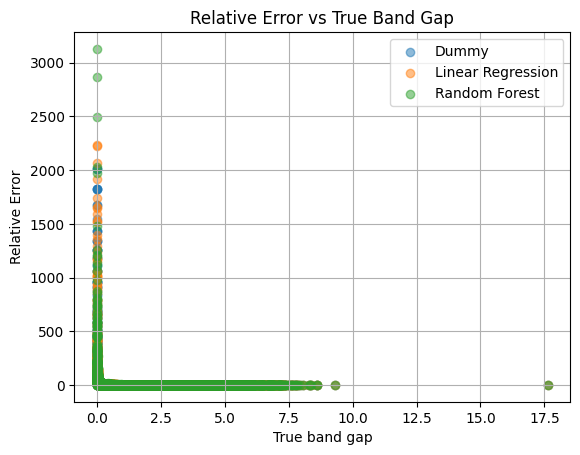

In [ ]:
# Fit on full training set and evaluate on test set
results = {}
print("\nTest set performance:")
for name, model in models.items():
    pipeline = make_pipeline(preprocessor, model)
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[name] = {"mae": mae, "r2": r2}

    print(f"{name}: MAE = {mae:.3f}, R² = {r2:.3f}")

    # Plot MAE vs true value
    relative_error = np.abs(y_pred - y_test) / y_test
    plt.scatter(y_test, relative_error, label=name, alpha=0.5)

    #plt.scatter(y_test, np.abs(y_pred - y_test), label=name, alpha=0.5)

plt.xlabel("True band gap")
plt.ylabel("Relative Error")
plt.title("Relative Error vs True Band Gap")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# # Feature importance of tree based model
# rf_model = make_pipeline(preprocessor, RandomForestRegressor(random_state=42))
# rf_model.fit(X_train, y_train)

# importances = rf_model.named_steps["randomforestregressor"].feature_importances_

# # Get feature names from the preprocessor
# feature_names = rf_model.named_steps["columntransformer"].get_feature_names_out()

# # Sort by importance
# sorted_idx = np.argsort(importances)[::-1][:20]
# top_features = np.array(feature_names)[sorted_idx]
# top_importances = importances[sorted_idx]

# plt.figure(figsize=(10, 6))
# sns.barplot(x=top_importances, y=top_features)
# plt.title("Top 20 Random Forest Feature Importances")
# plt.xlabel("Importance")
# plt.ylabel("Feature")
# plt.tight_layout()
# plt.show()


KeyboardInterrupt: 

# Feature importance using SHAP

In [ ]:
# # Feature importance using SHAP
# rf = rf_model.named_steps["randomforestregressor"]
# X_transformed = rf_model.named_steps["columntransformer"].transform(X_test)

# if hasattr(X_transformed, "toarray"):
#     X_transformed = X_transformed.toarray()

# feature_names = rf_model.named_steps["columntransformer"].get_feature_names_out()

# explainer = shap.TreeExplainer(rf)
# shap_values = explainer.shap_values(X_transformed)

# shap.summary_plot(shap_values, X_transformed, feature_names=feature_names)


In [ ]:
# # Using a faster SHAP explainer
# rf = rf_model.named_steps["randomforestregressor"]

# # Sample fewer rows for faster explanation
# X_sample = X_test.sample(250, random_state=42)

# # Transform using your pipeline
# X_transformed = rf_model.named_steps["columntransformer"].transform(X_sample)

# # Only convert if needed
# if hasattr(X_transformed, "toarray"):
#     X_transformed = X_transformed.toarray()

# # Get feature names
# feature_names = rf_model.named_steps["columntransformer"].get_feature_names_out()

# # Use SHAP's auto-detect explainer (faster in new versions)
# explainer = shap.Explainer(rf)

# # Compute SHAP values
# shap_values = explainer(X_transformed)

# # Summary plot
# shap.summary_plot(shap_values, X_transformed, feature_names=feature_names)


# Deep Learning Code

## Multilayer Perceptron (MLP)

In [ ]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Model training
# mlp = MLPRegressor(hidden_layer_sizes=(500, 50),
#                    batch_size=32,
#                    learning_rate_init=0.001,
#                    activation='relu',
#                    solver='adam',
#                    max_iter=500,
#                    random_state=42,
#                    early_stopping=True,
#                    validation_fraction=0.01,
#                    verbose=True)

# mlp.fit(X_train_processed, y_train)

Iteration 1, loss = 0.32849071
Validation score: 0.217295
Iteration 2, loss = 0.25874542
Validation score: 0.229804
Iteration 3, loss = 0.24624199
Validation score: 0.229363
Iteration 4, loss = 0.23651893
Validation score: 0.225040
Iteration 5, loss = 0.22996529
Validation score: 0.306302
Iteration 6, loss = 0.22511973
Validation score: 0.273042
Iteration 7, loss = 0.21827359
Validation score: 0.309634
Iteration 8, loss = 0.21443324
Validation score: 0.330448
Iteration 9, loss = 0.21014364
Validation score: 0.297989
Iteration 10, loss = 0.20625983
Validation score: 0.344994
Iteration 11, loss = 0.20266881
Validation score: 0.293596
Iteration 12, loss = 0.19925455
Validation score: 0.325306
Iteration 13, loss = 0.19559663
Validation score: 0.362221
Iteration 14, loss = 0.19206653
Validation score: 0.344506
Iteration 15, loss = 0.18764141
Validation score: 0.364928
Iteration 16, loss = 0.18653069
Validation score: 0.357117
Iteration 17, loss = 0.18379848
Validation score: 0.353925
Iterat

MLPRegressor(batch_size=32, early_stopping=True, hidden_layer_sizes=(500, 50),
             max_iter=500, random_state=42, validation_fraction=0.01,
             verbose=True)

In [ ]:
mlp = MLPRegressor(
    hidden_layer_sizes=(512, 256, 64),     # deeper & wider architecture
    activation='relu',                     # good default; try 'tanh' as well
    solver='adam',                         # adaptive optimizer
    alpha=1e-4,                            # L2 regularization (prevents overfitting)
    batch_size=32,                         # reasonable mini-batch size
    learning_rate='adaptive',              # allows decay if loss plateaus
    learning_rate_init=0.001,              # starting learning rate
    max_iter=1000,                         # more iterations for convergence
    early_stopping=True,                   # stop if no improvement on val
    validation_fraction=0.1,               # more validation data
    n_iter_no_change=20,                   # patience for early stopping
    random_state=42,
    verbose=True
)

mlp.fit(X_train_processed, y_train)

Iteration 1, loss = 0.83597124
Validation score: 0.375469
Iteration 2, loss = 0.73955677
Validation score: 0.402416
Iteration 3, loss = 0.69672106
Validation score: 0.416925
Iteration 4, loss = 0.67061408
Validation score: 0.459969
Iteration 5, loss = 0.64457770
Validation score: 0.473381
Iteration 6, loss = 0.62612703
Validation score: 0.477155
Iteration 7, loss = 0.60648886
Validation score: 0.466453
Iteration 8, loss = 0.58860904
Validation score: 0.489695
Iteration 9, loss = 0.57455431
Validation score: 0.501443
Iteration 10, loss = 0.55880841
Validation score: 0.485660
Iteration 11, loss = 0.54639937
Validation score: 0.501837
Iteration 12, loss = 0.53199809
Validation score: 0.510686
Iteration 13, loss = 0.52113577
Validation score: 0.495092
Iteration 14, loss = 0.50765451
Validation score: 0.518908
Iteration 15, loss = 0.49432054
Validation score: 0.505463
Iteration 16, loss = 0.48294069
Validation score: 0.512196
Iteration 17, loss = 0.47170624
Validation score: 0.515270
Iterat

MLPRegressor(batch_size=32, early_stopping=True,
             hidden_layer_sizes=(512, 256, 64), learning_rate='adaptive',
             max_iter=1000, n_iter_no_change=20, random_state=42, verbose=True)

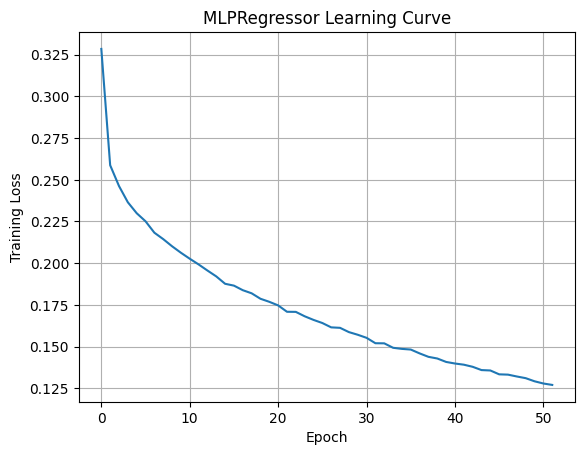

In [ ]:
# Plot learning curve
plt.plot(mlp.loss_curve_)
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("MLPRegressor Learning Curve")
plt.grid(True)
plt.show()

In [ ]:
# Evaluate performance
y_pred_sklearn = mlp.predict(X_test_processed)

mae_mlp = mean_absolute_error(y_test, y_pred_sklearn)
r2_mlp = r2_score(y_test, y_pred_sklearn)
mse_mlp = mean_squared_error(y_test, y_pred_sklearn)
rmse_mlp = np.sqrt(mse_mlp)

print(f"[MLPRegressor]")
print(f"MAE:  {mae_mlp:.4f}")
print(f"RMSE: {rmse_mlp:.4f}")
print(f"R²:   {r2_mlp:.4f}")


[MLPRegressor]
MAE:  0.8047
RMSE: 1.0788
R²:   0.5179


# Deep Neural Network

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_processed.toarray()
                              if hasattr(X_train_processed, "toarray")
                              else X_train_processed, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test_processed.toarray()
                             if hasattr(X_test_processed, "toarray")
                             else X_test_processed, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

## 3 Layers Network

In [ ]:
# Define model
class DeepRegressor(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)

        )

    def forward(self, x):

        return self.net(x)

model_layers3 = DeepRegressor(X_train_tensor.shape[1])


### Run the model on GPU if available

In [ ]:
# Put the model on the GPU if available
if torch.backends.mps.is_available():
    device = torch.device("mps")  # Use Metal GPU on Mac
elif torch.cuda.is_available():
    device = torch.device("cuda")  # Use NVIDIA GPU (not on Mac usually)
else:
    device = torch.device("cpu")  # Fallback

print("Using device:", device)

model_layers3.to(device)
X_train_tensor = X_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
X_test_tensor = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

print(X_train_tensor.device)
print(y_train_tensor.device)

Using device: mps
mps:0
mps:0


In [ ]:
# # Train model and register learning curve

# # Start timing
# start_time = time.time()

# # Define loss function: Mean Squared Error is commonly used for regression
# criterion = nn.MSELoss()

# # Define optimizer: Adam is an adaptive optimizer that generally performs well
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# # Lists to store training and test loss values at each epoch (for plotting/monitoring)
# train_losses = []
# test_losses = []

# # Set total number of training epochs
# n_epochs = 10000

# # Start the training loop
# for epoch in range(n_epochs):
#     # Set the model to training mode (activates dropout, batchnorm, etc. if used)
#     model.train()

#     # Clear previous gradients to prevent accumulation
#     optimizer.zero_grad()

#     # Forward pass: predict training outputs using current model weights
#     y_pred_train = model(X_train_tensor)

#     # Compute training loss by comparing predictions to ground truth
#     loss = criterion(y_pred_train, y_train_tensor)

#     # Backward pass: compute gradients of the loss w.r.t. model parameters
#     loss.backward()

#     # Update model weights using the computed gradients
#     optimizer.step()

#     # Switch model to evaluation mode (disables dropout, uses running stats for batchnorm)
#     model.eval()

#     # Disable gradient computation during inference to save memory and improve speed
#     with torch.no_grad():
#         # Predict outputs on the test set
#         y_pred_test = model(X_test_tensor)

#         # Compute test loss for evaluation
#         test_loss = criterion(y_pred_test, y_test_tensor)

#     # Record training and test loss values for this epoch
#     train_losses.append(loss.item())
#     test_losses.append(test_loss.item())

#     # Print progress every 10 epochs
#     if epoch % 10 == 0:
#         print(f"Epoch {epoch}: Train Loss={loss.item():.4f}, Test Loss={test_loss.item():.4f}")

# # End timing
# end_time = time.time()
# training_time_3layers = end_time - start_time
# print(f"Training time: {training_time_3layers:.2f} seconds")


### Define the training loop

In [ ]:
import time
from tqdm import trange
import torch
import torch.nn as nn
import torch.optim as optim

def train_model(
    model,
    X_train_tensor,
    y_train_tensor,
    X_test_tensor,
    y_test_tensor,
    n_epochs=5000,
    lr=0.001,
    weight_decay=0,
    early_stop_patience=200,
    scheduler_patience=50,
    scheduler_factor=0.5,
    verbose_every=10
):
    """
    Trains a PyTorch regression model with early stopping and learning rate scheduling.

    Returns:
        model: The trained model with best weights
        train_losses: List of training loss per epoch
        test_losses: List of test loss per epoch
    """

    # Setup
    start_time = time.time()
    criterion = nn.MSELoss()  # Mean squared error loss for regression
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)  # Adam optimizer
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=scheduler_factor, patience=scheduler_patience
    )  # Reduce LR on plateau

    train_losses = []
    test_losses = []
    best_loss = float('inf')
    trigger_times = 0

    for epoch in trange(n_epochs, desc="Training"):
        model.train()
        optimizer.zero_grad()
        y_pred_train = model(X_train_tensor)  # Forward pass on train set
        loss = criterion(y_pred_train, y_train_tensor)  # Compute train loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        model.eval()
        with torch.no_grad():
            y_pred_test = model(X_test_tensor)  # Forward pass on test set
            test_loss = criterion(y_pred_test, y_test_tensor)  # Compute test loss

        train_losses.append(loss.item())
        test_losses.append(test_loss.item())
        scheduler.step(test_loss.item())  # Step the LR scheduler

        # Early stopping logic
        if test_loss.item() < best_loss:
            best_loss = test_loss.item()
            best_model_state = model.state_dict()  # Save best model weights
            trigger_times = 0
        else:
            trigger_times += 1
            if trigger_times >= early_stop_patience:
                print(f"\n⏹️ Early stopping at epoch {epoch}")
                break
        if epoch % verbose_every == 0:
            print(f"Epoch {epoch:4d} | Train Loss: {loss.item():.4f} | Test Loss: {test_loss.item():.4f}")

    # Restore best model weights after training
    model.load_state_dict(best_model_state)

    # Report training time
    end_time = time.time()
    duration = end_time - start_time
    print(f"\n✅ Training completed in {duration:.2f} seconds ({duration / 60:.2f} minutes)")

    return model, train_losses, test_losses


### Train the Model

In [ ]:
model_layers3, train_losses_layers3, test_losses_layers3 = train_model(
    model_layers3,
    X_train_tensor,
    y_train_tensor,
    X_test_tensor,
    y_test_tensor,
    n_epochs=5000,
    lr=0.001,
    weight_decay=0,
    early_stop_patience=200,
    scheduler_patience=50,
    scheduler_factor=0.5,
    verbose_every=20
)

Training:   0%|          | 8/5000 [00:00<06:22, 13.04it/s]

Epoch    0 | Train Loss: 6.7655 | Test Loss: 6.4934


Training:   1%|          | 29/5000 [00:01<01:58, 41.81it/s]

Epoch   20 | Train Loss: 2.8621 | Test Loss: 2.7226


Training:   1%|          | 50/5000 [00:01<01:26, 57.09it/s]

Epoch   40 | Train Loss: 2.0949 | Test Loss: 2.0889


Training:   1%|▏         | 71/5000 [00:01<01:19, 62.16it/s]

Epoch   60 | Train Loss: 1.9328 | Test Loss: 1.9417


Training:   2%|▏         | 92/5000 [00:02<01:15, 64.90it/s]

Epoch   80 | Train Loss: 1.8695 | Test Loss: 1.8861


Training:   2%|▏         | 113/5000 [00:02<01:14, 65.98it/s]

Epoch  100 | Train Loss: 1.8322 | Test Loss: 1.8511


Training:   3%|▎         | 134/5000 [00:02<01:13, 66.53it/s]

Epoch  120 | Train Loss: 1.8057 | Test Loss: 1.8259


Training:   3%|▎         | 148/5000 [00:02<01:13, 66.46it/s]

Epoch  140 | Train Loss: 1.7836 | Test Loss: 1.8051


Training:   3%|▎         | 169/5000 [00:03<01:12, 66.71it/s]

Epoch  160 | Train Loss: 1.7633 | Test Loss: 1.7857


Training:   4%|▍         | 190/5000 [00:03<01:17, 61.96it/s]

Epoch  180 | Train Loss: 1.7438 | Test Loss: 1.7672


Training:   4%|▍         | 211/5000 [00:03<01:13, 64.87it/s]

Epoch  200 | Train Loss: 1.7245 | Test Loss: 1.7489


Training:   5%|▍         | 232/5000 [00:04<01:11, 66.29it/s]

Epoch  220 | Train Loss: 1.7043 | Test Loss: 1.7298


Training:   5%|▌         | 253/5000 [00:04<01:14, 64.05it/s]

Epoch  240 | Train Loss: 1.6814 | Test Loss: 1.7083


Training:   5%|▌         | 274/5000 [00:04<01:12, 64.96it/s]

Epoch  260 | Train Loss: 1.6564 | Test Loss: 1.6849


Training:   6%|▌         | 288/5000 [00:05<01:11, 65.64it/s]

Epoch  280 | Train Loss: 1.6305 | Test Loss: 1.6611


Training:   6%|▌         | 309/5000 [00:05<01:11, 65.97it/s]

Epoch  300 | Train Loss: 1.6050 | Test Loss: 1.6368


Training:   7%|▋         | 330/5000 [00:05<01:10, 66.55it/s]

Epoch  320 | Train Loss: 1.5793 | Test Loss: 1.6118


Training:   7%|▋         | 351/5000 [00:06<01:12, 64.39it/s]

Epoch  340 | Train Loss: 1.5534 | Test Loss: 1.5870


Training:   7%|▋         | 372/5000 [00:06<01:08, 67.20it/s]

Epoch  360 | Train Loss: 1.5267 | Test Loss: 1.5616


Training:   8%|▊         | 393/5000 [00:06<01:08, 67.41it/s]

Epoch  380 | Train Loss: 1.5011 | Test Loss: 1.5386


Training:   8%|▊         | 414/5000 [00:06<01:07, 68.10it/s]

Epoch  400 | Train Loss: 1.4780 | Test Loss: 1.5186


Training:   9%|▊         | 428/5000 [00:07<01:07, 68.10it/s]

Epoch  420 | Train Loss: 1.4572 | Test Loss: 1.5006


Training:   9%|▉         | 449/5000 [00:07<01:06, 68.11it/s]

Epoch  440 | Train Loss: 1.4372 | Test Loss: 1.4839


Training:   9%|▉         | 470/5000 [00:07<01:06, 68.09it/s]

Epoch  460 | Train Loss: 1.4173 | Test Loss: 1.4676


Training:  10%|▉         | 491/5000 [00:08<01:06, 67.78it/s]

Epoch  480 | Train Loss: 1.3973 | Test Loss: 1.4510


Training:  10%|█         | 512/5000 [00:08<01:06, 67.77it/s]

Epoch  500 | Train Loss: 1.3782 | Test Loss: 1.4353


Training:  11%|█         | 533/5000 [00:08<01:05, 68.00it/s]

Epoch  520 | Train Loss: 1.3603 | Test Loss: 1.4214


Training:  11%|█         | 554/5000 [00:09<01:05, 67.85it/s]

Epoch  540 | Train Loss: 1.3432 | Test Loss: 1.4084


Training:  11%|█▏        | 568/5000 [00:09<01:05, 67.89it/s]

Epoch  560 | Train Loss: 1.3270 | Test Loss: 1.3969


Training:  12%|█▏        | 589/5000 [00:09<01:07, 65.04it/s]

Epoch  580 | Train Loss: 1.3116 | Test Loss: 1.3856


Training:  12%|█▏        | 610/5000 [00:09<01:05, 67.02it/s]

Epoch  600 | Train Loss: 1.2974 | Test Loss: 1.3753


Training:  13%|█▎        | 631/5000 [00:10<01:04, 67.65it/s]

Epoch  620 | Train Loss: 1.2843 | Test Loss: 1.3664


Training:  13%|█▎        | 652/5000 [00:10<01:04, 67.71it/s]

Epoch  640 | Train Loss: 1.2722 | Test Loss: 1.3578


Training:  13%|█▎        | 673/5000 [00:10<01:04, 67.35it/s]

Epoch  660 | Train Loss: 1.2609 | Test Loss: 1.3497


Training:  14%|█▍        | 694/5000 [00:11<01:03, 67.86it/s]

Epoch  680 | Train Loss: 1.2501 | Test Loss: 1.3425


Training:  14%|█▍        | 708/5000 [00:11<01:03, 67.77it/s]

Epoch  700 | Train Loss: 1.2404 | Test Loss: 1.3365


Training:  15%|█▍        | 729/5000 [00:11<01:02, 68.03it/s]

Epoch  720 | Train Loss: 1.2317 | Test Loss: 1.3309


Training:  15%|█▌        | 750/5000 [00:11<01:02, 68.02it/s]

Epoch  740 | Train Loss: 1.2237 | Test Loss: 1.3259


Training:  15%|█▌        | 771/5000 [00:12<01:01, 68.24it/s]

Epoch  760 | Train Loss: 1.2163 | Test Loss: 1.3222


Training:  16%|█▌        | 792/5000 [00:12<01:01, 68.41it/s]

Epoch  780 | Train Loss: 1.2086 | Test Loss: 1.3182


Training:  16%|█▋        | 813/5000 [00:12<01:01, 68.27it/s]

Epoch  800 | Train Loss: 1.2014 | Test Loss: 1.3148


Training:  17%|█▋        | 834/5000 [00:13<01:01, 68.06it/s]

Epoch  820 | Train Loss: 1.1945 | Test Loss: 1.3108


Training:  17%|█▋        | 848/5000 [00:13<01:01, 67.64it/s]

Epoch  840 | Train Loss: 1.1881 | Test Loss: 1.3075


Training:  17%|█▋        | 869/5000 [00:13<01:00, 68.19it/s]

Epoch  860 | Train Loss: 1.1821 | Test Loss: 1.3051


Training:  18%|█▊        | 890/5000 [00:14<01:03, 64.86it/s]

Epoch  880 | Train Loss: 1.1758 | Test Loss: 1.3024


Training:  18%|█▊        | 911/5000 [00:14<01:01, 66.58it/s]

Epoch  900 | Train Loss: 1.1707 | Test Loss: 1.3003


Training:  19%|█▊        | 932/5000 [00:14<00:59, 68.01it/s]

Epoch  920 | Train Loss: 1.1645 | Test Loss: 1.2969


Training:  19%|█▉        | 953/5000 [00:14<00:59, 68.33it/s]

Epoch  940 | Train Loss: 1.1604 | Test Loss: 1.2981


Training:  19%|█▉        | 974/5000 [00:15<00:59, 67.35it/s]

Epoch  960 | Train Loss: 1.1547 | Test Loss: 1.2942


Training:  20%|█▉        | 988/5000 [00:15<01:00, 66.33it/s]

Epoch  980 | Train Loss: 1.1497 | Test Loss: 1.2922


Training:  20%|██        | 1009/5000 [00:15<00:59, 67.50it/s]

Epoch 1000 | Train Loss: 1.1452 | Test Loss: 1.2903


Training:  21%|██        | 1030/5000 [00:16<00:58, 68.14it/s]

Epoch 1020 | Train Loss: 1.1414 | Test Loss: 1.2890


Training:  21%|██        | 1051/5000 [00:16<00:57, 68.12it/s]

Epoch 1040 | Train Loss: 1.1378 | Test Loss: 1.2889


Training:  21%|██▏       | 1073/5000 [00:16<00:57, 68.66it/s]

Epoch 1060 | Train Loss: 1.1328 | Test Loss: 1.2852


Training:  22%|██▏       | 1094/5000 [00:17<00:56, 68.61it/s]

Epoch 1080 | Train Loss: 1.1289 | Test Loss: 1.2841


Training:  22%|██▏       | 1108/5000 [00:17<00:57, 68.26it/s]

Epoch 1100 | Train Loss: 1.1253 | Test Loss: 1.2827


Training:  23%|██▎       | 1129/5000 [00:17<00:56, 67.96it/s]

Epoch 1120 | Train Loss: 1.1216 | Test Loss: 1.2815


Training:  23%|██▎       | 1150/5000 [00:17<00:58, 65.44it/s]

Epoch 1140 | Train Loss: 1.1175 | Test Loss: 1.2793


Training:  23%|██▎       | 1172/5000 [00:18<00:56, 68.26it/s]

Epoch 1160 | Train Loss: 1.1146 | Test Loss: 1.2796


Training:  24%|██▍       | 1193/5000 [00:18<00:55, 68.72it/s]

Epoch 1180 | Train Loss: 1.1122 | Test Loss: 1.2775


Training:  24%|██▍       | 1214/5000 [00:18<00:55, 68.40it/s]

Epoch 1200 | Train Loss: 1.1076 | Test Loss: 1.2753


Training:  25%|██▍       | 1228/5000 [00:19<00:55, 68.19it/s]

Epoch 1220 | Train Loss: 1.1045 | Test Loss: 1.2743


Training:  25%|██▍       | 1249/5000 [00:19<00:54, 68.71it/s]

Epoch 1240 | Train Loss: 1.1018 | Test Loss: 1.2737


Training:  25%|██▌       | 1271/5000 [00:19<00:53, 69.12it/s]

Epoch 1260 | Train Loss: 1.0987 | Test Loss: 1.2722


Training:  26%|██▌       | 1292/5000 [00:19<00:55, 66.64it/s]

Epoch 1280 | Train Loss: 1.0960 | Test Loss: 1.2719


Training:  26%|██▋       | 1313/5000 [00:20<00:55, 66.63it/s]

Epoch 1300 | Train Loss: 1.0955 | Test Loss: 1.2732


Training:  27%|██▋       | 1334/5000 [00:20<00:54, 67.39it/s]

Epoch 1320 | Train Loss: 1.0902 | Test Loss: 1.2712


Training:  27%|██▋       | 1348/5000 [00:20<00:53, 67.90it/s]

Epoch 1340 | Train Loss: 1.0877 | Test Loss: 1.2708


Training:  27%|██▋       | 1370/5000 [00:21<00:52, 69.02it/s]

Epoch 1360 | Train Loss: 1.0851 | Test Loss: 1.2707


Training:  28%|██▊       | 1393/5000 [00:21<00:51, 69.69it/s]

Epoch 1380 | Train Loss: 1.0826 | Test Loss: 1.2700


Training:  28%|██▊       | 1414/5000 [00:21<00:51, 69.44it/s]

Epoch 1400 | Train Loss: 1.0804 | Test Loss: 1.2700


Training:  29%|██▊       | 1428/5000 [00:21<00:52, 68.20it/s]

Epoch 1420 | Train Loss: 1.0786 | Test Loss: 1.2691


Training:  29%|██▉       | 1449/5000 [00:22<00:52, 67.89it/s]

Epoch 1440 | Train Loss: 1.0760 | Test Loss: 1.2688


Training:  29%|██▉       | 1470/5000 [00:22<00:55, 63.75it/s]

Epoch 1460 | Train Loss: 1.0743 | Test Loss: 1.2690


Training:  30%|██▉       | 1491/5000 [00:22<00:52, 66.25it/s]

Epoch 1480 | Train Loss: 1.0727 | Test Loss: 1.2684


Training:  30%|███       | 1512/5000 [00:23<00:51, 67.22it/s]

Epoch 1500 | Train Loss: 1.0696 | Test Loss: 1.2681


Training:  31%|███       | 1533/5000 [00:23<00:52, 66.52it/s]

Epoch 1520 | Train Loss: 1.0673 | Test Loss: 1.2670


Training:  31%|███       | 1554/5000 [00:23<00:50, 67.87it/s]

Epoch 1540 | Train Loss: 1.0691 | Test Loss: 1.2718


Training:  31%|███▏      | 1568/5000 [00:24<00:50, 68.17it/s]

Epoch 1560 | Train Loss: 1.0632 | Test Loss: 1.2668


Training:  32%|███▏      | 1589/5000 [00:24<00:49, 68.59it/s]

Epoch 1580 | Train Loss: 1.0612 | Test Loss: 1.2660


Training:  32%|███▏      | 1610/5000 [00:24<00:49, 68.34it/s]

Epoch 1600 | Train Loss: 1.0600 | Test Loss: 1.2662


Training:  33%|███▎      | 1631/5000 [00:24<00:49, 68.55it/s]

Epoch 1620 | Train Loss: 1.0587 | Test Loss: 1.2669


Training:  33%|███▎      | 1652/5000 [00:25<00:48, 68.37it/s]

Epoch 1640 | Train Loss: 1.0554 | Test Loss: 1.2644


Training:  33%|███▎      | 1673/5000 [00:25<00:49, 67.82it/s]

Epoch 1660 | Train Loss: 1.0537 | Test Loss: 1.2643


Training:  34%|███▍      | 1694/5000 [00:25<00:49, 67.24it/s]

Epoch 1680 | Train Loss: 1.0520 | Test Loss: 1.2646


Training:  34%|███▍      | 1708/5000 [00:26<00:48, 67.55it/s]

Epoch 1700 | Train Loss: 1.0500 | Test Loss: 1.2635


Training:  35%|███▍      | 1729/5000 [00:26<00:48, 68.00it/s]

Epoch 1720 | Train Loss: 1.0515 | Test Loss: 1.2652


Training:  35%|███▌      | 1750/5000 [00:26<00:47, 68.45it/s]

Epoch 1740 | Train Loss: 1.0470 | Test Loss: 1.2627


Training:  35%|███▌      | 1771/5000 [00:27<00:47, 68.27it/s]

Epoch 1760 | Train Loss: 1.0454 | Test Loss: 1.2633


Training:  36%|███▌      | 1792/5000 [00:27<00:46, 68.62it/s]

Epoch 1780 | Train Loss: 1.0438 | Test Loss: 1.2620


Training:  36%|███▋      | 1813/5000 [00:27<00:46, 68.35it/s]

Epoch 1800 | Train Loss: 1.0460 | Test Loss: 1.2654


Training:  37%|███▋      | 1834/5000 [00:27<00:46, 68.55it/s]

Epoch 1820 | Train Loss: 1.0411 | Test Loss: 1.2616


Training:  37%|███▋      | 1848/5000 [00:28<00:46, 68.43it/s]

Epoch 1840 | Train Loss: 1.0392 | Test Loss: 1.2618


Training:  37%|███▋      | 1869/5000 [00:28<00:45, 68.61it/s]

Epoch 1860 | Train Loss: 1.0384 | Test Loss: 1.2630


Training:  38%|███▊      | 1890/5000 [00:28<00:45, 68.62it/s]

Epoch 1880 | Train Loss: 1.0365 | Test Loss: 1.2616


Training:  38%|███▊      | 1911/5000 [00:29<00:45, 68.18it/s]

Epoch 1900 | Train Loss: 1.0357 | Test Loss: 1.2610


Training:  39%|███▊      | 1932/5000 [00:29<00:44, 68.51it/s]

Epoch 1920 | Train Loss: 1.0349 | Test Loss: 1.2608


Training:  39%|███▉      | 1946/5000 [00:29<00:49, 61.87it/s]

Epoch 1940 | Train Loss: 1.0341 | Test Loss: 1.2605


Training:  39%|███▉      | 1974/5000 [00:30<00:46, 65.64it/s]

Epoch 1960 | Train Loss: 1.0333 | Test Loss: 1.2603


Training:  40%|███▉      | 1988/5000 [00:30<00:45, 66.90it/s]

Epoch 1980 | Train Loss: 1.0326 | Test Loss: 1.2602


Training:  40%|████      | 2009/5000 [00:30<00:44, 67.81it/s]

Epoch 2000 | Train Loss: 1.0318 | Test Loss: 1.2600


Training:  41%|████      | 2030/5000 [00:30<00:43, 68.32it/s]

Epoch 2020 | Train Loss: 1.0310 | Test Loss: 1.2599


Training:  41%|████      | 2051/5000 [00:31<00:43, 68.33it/s]

Epoch 2040 | Train Loss: 1.0301 | Test Loss: 1.2596


Training:  41%|████▏     | 2072/5000 [00:31<00:42, 68.22it/s]

Epoch 2060 | Train Loss: 1.0293 | Test Loss: 1.2592


Training:  42%|████▏     | 2093/5000 [00:31<00:42, 68.55it/s]

Epoch 2080 | Train Loss: 1.0285 | Test Loss: 1.2590


Training:  42%|████▏     | 2114/5000 [00:32<00:42, 68.59it/s]

Epoch 2100 | Train Loss: 1.0277 | Test Loss: 1.2589


Training:  43%|████▎     | 2128/5000 [00:32<00:41, 68.44it/s]

Epoch 2120 | Train Loss: 1.0268 | Test Loss: 1.2587


Training:  43%|████▎     | 2149/5000 [00:32<00:41, 68.47it/s]

Epoch 2140 | Train Loss: 1.0260 | Test Loss: 1.2584


Training:  43%|████▎     | 2170/5000 [00:32<00:41, 68.26it/s]

Epoch 2160 | Train Loss: 1.0252 | Test Loss: 1.2581


Training:  44%|████▍     | 2191/5000 [00:33<00:41, 67.00it/s]

Epoch 2180 | Train Loss: 1.0243 | Test Loss: 1.2578


Training:  44%|████▍     | 2212/5000 [00:33<00:40, 68.08it/s]

Epoch 2200 | Train Loss: 1.0234 | Test Loss: 1.2574


Training:  45%|████▍     | 2233/5000 [00:33<00:40, 68.15it/s]

Epoch 2220 | Train Loss: 1.0226 | Test Loss: 1.2571


Training:  45%|████▍     | 2247/5000 [00:34<00:40, 67.62it/s]

Epoch 2240 | Train Loss: 1.0217 | Test Loss: 1.2567


Training:  45%|████▌     | 2268/5000 [00:34<00:41, 65.52it/s]

Epoch 2260 | Train Loss: 1.0209 | Test Loss: 1.2563


Training:  46%|████▌     | 2289/5000 [00:34<00:40, 67.56it/s]

Epoch 2280 | Train Loss: 1.0200 | Test Loss: 1.2560


Training:  46%|████▌     | 2310/5000 [00:35<00:39, 68.36it/s]

Epoch 2300 | Train Loss: 1.0191 | Test Loss: 1.2556


Training:  47%|████▋     | 2331/5000 [00:35<00:39, 67.78it/s]

Epoch 2320 | Train Loss: 1.0182 | Test Loss: 1.2553


Training:  47%|████▋     | 2352/5000 [00:35<00:39, 67.82it/s]

Epoch 2340 | Train Loss: 1.0173 | Test Loss: 1.2550


Training:  47%|████▋     | 2373/5000 [00:35<00:38, 67.74it/s]

Epoch 2360 | Train Loss: 1.0164 | Test Loss: 1.2548


Training:  48%|████▊     | 2394/5000 [00:36<00:38, 67.66it/s]

Epoch 2380 | Train Loss: 1.0154 | Test Loss: 1.2544


Training:  48%|████▊     | 2408/5000 [00:36<00:38, 66.67it/s]

Epoch 2400 | Train Loss: 1.0145 | Test Loss: 1.2542


Training:  49%|████▊     | 2429/5000 [00:36<00:38, 67.49it/s]

Epoch 2420 | Train Loss: 1.0135 | Test Loss: 1.2539


Training:  49%|████▉     | 2450/5000 [00:37<00:37, 67.80it/s]

Epoch 2440 | Train Loss: 1.0126 | Test Loss: 1.2535


Training:  49%|████▉     | 2471/5000 [00:37<00:37, 68.15it/s]

Epoch 2460 | Train Loss: 1.0116 | Test Loss: 1.2533


Training:  50%|████▉     | 2492/5000 [00:37<00:36, 68.13it/s]

Epoch 2480 | Train Loss: 1.0106 | Test Loss: 1.2530


Training:  50%|█████     | 2513/5000 [00:38<00:36, 68.30it/s]

Epoch 2500 | Train Loss: 1.0096 | Test Loss: 1.2526


Training:  51%|█████     | 2534/5000 [00:38<00:37, 65.08it/s]

Epoch 2520 | Train Loss: 1.0086 | Test Loss: 1.2521


Training:  51%|█████     | 2548/5000 [00:38<00:36, 66.73it/s]

Epoch 2540 | Train Loss: 1.0076 | Test Loss: 1.2517


Training:  51%|█████▏    | 2570/5000 [00:38<00:35, 68.28it/s]

Epoch 2560 | Train Loss: 1.0066 | Test Loss: 1.2514


Training:  52%|█████▏    | 2591/5000 [00:39<00:35, 68.49it/s]

Epoch 2580 | Train Loss: 1.0056 | Test Loss: 1.2509


Training:  52%|█████▏    | 2612/5000 [00:39<00:34, 68.88it/s]

Epoch 2600 | Train Loss: 1.0046 | Test Loss: 1.2509


Training:  53%|█████▎    | 2633/5000 [00:39<00:34, 68.55it/s]

Epoch 2620 | Train Loss: 1.0036 | Test Loss: 1.2508


Training:  53%|█████▎    | 2654/5000 [00:40<00:34, 67.06it/s]

Epoch 2640 | Train Loss: 1.0026 | Test Loss: 1.2506


Training:  53%|█████▎    | 2668/5000 [00:40<00:34, 67.81it/s]

Epoch 2660 | Train Loss: 1.0015 | Test Loss: 1.2503


Training:  54%|█████▍    | 2689/5000 [00:40<00:33, 68.63it/s]

Epoch 2680 | Train Loss: 1.0006 | Test Loss: 1.2497


Training:  54%|█████▍    | 2710/5000 [00:40<00:33, 68.37it/s]

Epoch 2700 | Train Loss: 0.9997 | Test Loss: 1.2499


Training:  55%|█████▍    | 2731/5000 [00:41<00:33, 68.57it/s]

Epoch 2720 | Train Loss: 0.9987 | Test Loss: 1.2493


Training:  55%|█████▌    | 2752/5000 [00:41<00:32, 68.86it/s]

Epoch 2740 | Train Loss: 0.9977 | Test Loss: 1.2492


Training:  55%|█████▌    | 2766/5000 [00:41<00:36, 61.34it/s]

Epoch 2760 | Train Loss: 0.9965 | Test Loss: 1.2489


Training:  56%|█████▌    | 2794/5000 [00:42<00:32, 66.98it/s]

Epoch 2780 | Train Loss: 0.9953 | Test Loss: 1.2487


Training:  56%|█████▌    | 2808/5000 [00:42<00:32, 68.05it/s]

Epoch 2800 | Train Loss: 0.9948 | Test Loss: 1.2494


Training:  57%|█████▋    | 2829/5000 [00:42<00:31, 68.60it/s]

Epoch 2820 | Train Loss: 0.9934 | Test Loss: 1.2485


Training:  57%|█████▋    | 2850/5000 [00:43<00:31, 68.58it/s]

Epoch 2840 | Train Loss: 0.9922 | Test Loss: 1.2483


Training:  57%|█████▋    | 2872/5000 [00:43<00:31, 67.28it/s]

Epoch 2860 | Train Loss: 0.9909 | Test Loss: 1.2476


Training:  58%|█████▊    | 2893/5000 [00:43<00:30, 68.16it/s]

Epoch 2880 | Train Loss: 0.9898 | Test Loss: 1.2473


Training:  58%|█████▊    | 2914/5000 [00:43<00:30, 68.88it/s]

Epoch 2900 | Train Loss: 0.9888 | Test Loss: 1.2474


Training:  59%|█████▊    | 2928/5000 [00:44<00:30, 68.58it/s]

Epoch 2920 | Train Loss: 0.9876 | Test Loss: 1.2472


Training:  59%|█████▉    | 2949/5000 [00:44<00:29, 68.81it/s]

Epoch 2940 | Train Loss: 0.9865 | Test Loss: 1.2467


Training:  59%|█████▉    | 2971/5000 [00:44<00:29, 69.32it/s]

Epoch 2960 | Train Loss: 0.9855 | Test Loss: 1.2464


Training:  60%|█████▉    | 2992/5000 [00:45<00:29, 69.23it/s]

Epoch 2980 | Train Loss: 0.9842 | Test Loss: 1.2462


Training:  60%|██████    | 3013/5000 [00:45<00:29, 68.36it/s]

Epoch 3000 | Train Loss: 0.9836 | Test Loss: 1.2460


Training:  61%|██████    | 3034/5000 [00:45<00:28, 68.23it/s]

Epoch 3020 | Train Loss: 0.9822 | Test Loss: 1.2455


Training:  61%|██████    | 3048/5000 [00:45<00:28, 67.70it/s]

Epoch 3040 | Train Loss: 0.9812 | Test Loss: 1.2453


Training:  61%|██████▏   | 3069/5000 [00:46<00:29, 65.32it/s]

Epoch 3060 | Train Loss: 0.9801 | Test Loss: 1.2452


Training:  62%|██████▏   | 3090/5000 [00:46<00:28, 66.62it/s]

Epoch 3080 | Train Loss: 0.9790 | Test Loss: 1.2448


Training:  62%|██████▏   | 3111/5000 [00:46<00:27, 67.48it/s]

Epoch 3100 | Train Loss: 0.9784 | Test Loss: 1.2449


Training:  63%|██████▎   | 3132/5000 [00:47<00:27, 68.16it/s]

Epoch 3120 | Train Loss: 0.9769 | Test Loss: 1.2445


Training:  63%|██████▎   | 3153/5000 [00:47<00:26, 68.49it/s]

Epoch 3140 | Train Loss: 0.9760 | Test Loss: 1.2442


Training:  63%|██████▎   | 3174/5000 [00:47<00:26, 68.38it/s]

Epoch 3160 | Train Loss: 0.9750 | Test Loss: 1.2444


Training:  64%|██████▍   | 3188/5000 [00:47<00:26, 68.50it/s]

Epoch 3180 | Train Loss: 0.9736 | Test Loss: 1.2438


Training:  64%|██████▍   | 3209/5000 [00:48<00:26, 68.77it/s]

Epoch 3200 | Train Loss: 0.9727 | Test Loss: 1.2441


Training:  65%|██████▍   | 3230/5000 [00:48<00:25, 68.73it/s]

Epoch 3220 | Train Loss: 0.9716 | Test Loss: 1.2435


Training:  65%|██████▌   | 3251/5000 [00:48<00:25, 68.77it/s]

Epoch 3240 | Train Loss: 0.9705 | Test Loss: 1.2432


Training:  65%|██████▌   | 3272/5000 [00:49<00:25, 68.91it/s]

Epoch 3260 | Train Loss: 0.9695 | Test Loss: 1.2429


Training:  66%|██████▌   | 3286/5000 [00:49<00:28, 59.79it/s]

Epoch 3280 | Train Loss: 0.9686 | Test Loss: 1.2426


Training:  66%|██████▋   | 3315/5000 [00:49<00:25, 66.85it/s]

Epoch 3300 | Train Loss: 0.9676 | Test Loss: 1.2426


Training:  67%|██████▋   | 3329/5000 [00:50<00:24, 67.91it/s]

Epoch 3320 | Train Loss: 0.9670 | Test Loss: 1.2428


Training:  67%|██████▋   | 3350/5000 [00:50<00:23, 68.81it/s]

Epoch 3340 | Train Loss: 0.9660 | Test Loss: 1.2425


Training:  67%|██████▋   | 3372/5000 [00:50<00:23, 69.16it/s]

Epoch 3360 | Train Loss: 0.9652 | Test Loss: 1.2424


Training:  68%|██████▊   | 3393/5000 [00:51<00:23, 69.07it/s]

Epoch 3380 | Train Loss: 0.9647 | Test Loss: 1.2423


Training:  68%|██████▊   | 3414/5000 [00:51<00:22, 69.03it/s]

Epoch 3400 | Train Loss: 0.9643 | Test Loss: 1.2423


Training:  69%|██████▊   | 3428/5000 [00:51<00:22, 68.74it/s]

Epoch 3420 | Train Loss: 0.9641 | Test Loss: 1.2423


Training:  69%|██████▉   | 3450/5000 [00:51<00:22, 69.14it/s]

Epoch 3440 | Train Loss: 0.9638 | Test Loss: 1.2423


Training:  69%|██████▉   | 3471/5000 [00:52<00:22, 68.84it/s]

Epoch 3460 | Train Loss: 0.9637 | Test Loss: 1.2423


Training:  70%|██████▉   | 3492/5000 [00:52<00:22, 68.08it/s]

Epoch 3480 | Train Loss: 0.9636 | Test Loss: 1.2423


Training:  70%|███████   | 3513/5000 [00:52<00:21, 68.61it/s]

Epoch 3500 | Train Loss: 0.9635 | Test Loss: 1.2423


Training:  71%|███████   | 3534/5000 [00:53<00:21, 68.67it/s]

Epoch 3520 | Train Loss: 0.9634 | Test Loss: 1.2423


Training:  71%|███████   | 3548/5000 [00:53<00:21, 68.25it/s]

Epoch 3540 | Train Loss: 0.9633 | Test Loss: 1.2423


Training:  71%|███████▏  | 3569/5000 [00:53<00:22, 63.06it/s]

Epoch 3560 | Train Loss: 0.9633 | Test Loss: 1.2423


Training:  72%|███████▏  | 3590/5000 [00:53<00:21, 66.77it/s]

Epoch 3580 | Train Loss: 0.9633 | Test Loss: 1.2423


Training:  72%|███████▏  | 3611/5000 [00:54<00:20, 67.74it/s]

Epoch 3600 | Train Loss: 0.9632 | Test Loss: 1.2423


Training:  73%|███████▎  | 3632/5000 [00:54<00:20, 68.17it/s]

Epoch 3620 | Train Loss: 0.9632 | Test Loss: 1.2423


Training:  73%|███████▎  | 3653/5000 [00:54<00:19, 68.32it/s]

Epoch 3640 | Train Loss: 0.9632 | Test Loss: 1.2423


Training:  73%|███████▎  | 3674/5000 [00:55<00:19, 67.58it/s]

Epoch 3660 | Train Loss: 0.9632 | Test Loss: 1.2423


Training:  74%|███████▍  | 3688/5000 [00:55<00:19, 67.52it/s]

Epoch 3680 | Train Loss: 0.9632 | Test Loss: 1.2423


Training:  74%|███████▍  | 3709/5000 [00:55<00:19, 67.60it/s]

Epoch 3700 | Train Loss: 0.9632 | Test Loss: 1.2422


Training:  75%|███████▍  | 3730/5000 [00:55<00:18, 67.66it/s]

Epoch 3720 | Train Loss: 0.9632 | Test Loss: 1.2422


Training:  75%|███████▌  | 3751/5000 [00:56<00:18, 68.02it/s]

Epoch 3740 | Train Loss: 0.9632 | Test Loss: 1.2422


Training:  75%|███████▌  | 3772/5000 [00:56<00:17, 68.24it/s]

Epoch 3760 | Train Loss: 0.9631 | Test Loss: 1.2422


Training:  76%|███████▌  | 3793/5000 [00:56<00:17, 68.76it/s]

Epoch 3780 | Train Loss: 0.9631 | Test Loss: 1.2422


Training:  76%|███████▋  | 3814/5000 [00:57<00:17, 68.71it/s]

Epoch 3800 | Train Loss: 0.9631 | Test Loss: 1.2422


Training:  77%|███████▋  | 3828/5000 [00:57<00:17, 68.35it/s]

Epoch 3820 | Train Loss: 0.9631 | Test Loss: 1.2422


Training:  77%|███████▋  | 3849/5000 [00:57<00:18, 62.76it/s]

Epoch 3840 | Train Loss: 0.9631 | Test Loss: 1.2422


Training:  77%|███████▋  | 3870/5000 [00:58<00:17, 65.87it/s]

Epoch 3860 | Train Loss: 0.9631 | Test Loss: 1.2422


Training:  78%|███████▊  | 3891/5000 [00:58<00:16, 67.11it/s]

Epoch 3880 | Train Loss: 0.9631 | Test Loss: 1.2422


Training:  78%|███████▊  | 3912/5000 [00:58<00:16, 67.42it/s]

Epoch 3900 | Train Loss: 0.9631 | Test Loss: 1.2422


Training:  79%|███████▊  | 3933/5000 [00:59<00:15, 67.46it/s]

Epoch 3920 | Train Loss: 0.9631 | Test Loss: 1.2422


Training:  79%|███████▉  | 3954/5000 [00:59<00:15, 67.59it/s]

Epoch 3940 | Train Loss: 0.9631 | Test Loss: 1.2422


Training:  79%|███████▉  | 3968/5000 [00:59<00:15, 67.51it/s]

Epoch 3960 | Train Loss: 0.9631 | Test Loss: 1.2422


Training:  80%|███████▉  | 3989/5000 [00:59<00:15, 67.30it/s]

Epoch 3980 | Train Loss: 0.9631 | Test Loss: 1.2422


Training:  80%|████████  | 4010/5000 [01:00<00:14, 67.89it/s]

Epoch 4000 | Train Loss: 0.9631 | Test Loss: 1.2422


Training:  81%|████████  | 4031/5000 [01:00<00:14, 67.97it/s]

Epoch 4020 | Train Loss: 0.9631 | Test Loss: 1.2422


Training:  81%|████████  | 4052/5000 [01:00<00:14, 66.86it/s]

Epoch 4040 | Train Loss: 0.9631 | Test Loss: 1.2422


Training:  81%|████████▏ | 4073/5000 [01:01<00:13, 67.95it/s]

Epoch 4060 | Train Loss: 0.9631 | Test Loss: 1.2422


Training:  82%|████████▏ | 4094/5000 [01:01<00:13, 68.37it/s]

Epoch 4080 | Train Loss: 0.9631 | Test Loss: 1.2422


Training:  82%|████████▏ | 4108/5000 [01:01<00:14, 63.54it/s]

Epoch 4100 | Train Loss: 0.9631 | Test Loss: 1.2422


Training:  83%|████████▎ | 4129/5000 [01:01<00:13, 66.72it/s]

Epoch 4120 | Train Loss: 0.9631 | Test Loss: 1.2422


Training:  83%|████████▎ | 4150/5000 [01:02<00:12, 67.89it/s]

Epoch 4140 | Train Loss: 0.9631 | Test Loss: 1.2422


Training:  83%|████████▎ | 4172/5000 [01:02<00:12, 68.98it/s]

Epoch 4160 | Train Loss: 0.9631 | Test Loss: 1.2422


Training:  84%|████████▍ | 4193/5000 [01:02<00:11, 69.29it/s]

Epoch 4180 | Train Loss: 0.9631 | Test Loss: 1.2422


Training:  84%|████████▍ | 4214/5000 [01:03<00:11, 67.62it/s]

Epoch 4200 | Train Loss: 0.9631 | Test Loss: 1.2422


Training:  85%|████████▍ | 4228/5000 [01:03<00:11, 68.25it/s]

Epoch 4220 | Train Loss: 0.9631 | Test Loss: 1.2422


Training:  85%|████████▍ | 4249/5000 [01:03<00:10, 69.01it/s]

Epoch 4240 | Train Loss: 0.9631 | Test Loss: 1.2422


Training:  85%|████████▌ | 4270/5000 [01:04<00:10, 68.95it/s]

Epoch 4260 | Train Loss: 0.9631 | Test Loss: 1.2422


Training:  86%|████████▌ | 4283/5000 [01:04<00:10, 66.71it/s]

Epoch 4280 | Train Loss: 0.9631 | Test Loss: 1.2422

⏹️ Early stopping at epoch 4283

✅ Training completed in 65.09 seconds (1.08 minutes)


### Evaluate the model

In [ ]:
# Model evaluation
def evaluate_model(model, X_train_tensor, y_train, X_test_tensor, y_test, y_train_tensor=None):
    """
    Evaluates a trained PyTorch regression model on both training and test sets.

    Returns:
        Dictionary of metrics (MAE, RMSE, R²) for train and test sets
    """
    model.eval()

    with torch.no_grad():
        y_pred_test = model(X_test_tensor).detach().cpu().numpy()
        y_pred_train = model(X_train_tensor).detach().cpu().numpy()


    # Evaluate on test set
    mae_test = mean_absolute_error(y_test, y_pred_test)
    mse_test = mean_squared_error(y_test, y_pred_test)
    rmse_test = np.sqrt(mse_test)
    r2_test = r2_score(y_test, y_pred_test)

    # Evaluate on train set
    mae_train = mean_absolute_error(y_train, y_pred_train)
    mse_train = mean_squared_error(y_train, y_pred_train)
    rmse_train = np.sqrt(mse_train)
    r2_train = r2_score(y_train, y_pred_train)

    return {
        "test": {"MAE": mae_test, "RMSE": rmse_test, "R2": r2_test, "y_pred_test": y_pred_test},
        "train": {"MAE": mae_train, "RMSE": rmse_train, "R2": r2_train, "y_pred_train": y_pred_train}
    }

### Analyze the model

In [ ]:
# Plot learning curves
import matplotlib.pyplot as plt

def analyze_model(metrics, y_test,
                  train_losses, test_losses, model_name="PyTorch Model"):
    """
    Plots learning curves, prints metrics, and plots predicted vs. true values.
    """

    # 2. Plot learning curves
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(test_losses, label="Test Loss")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.title(f"{model_name} Learning Curve")
    plt.legend()
    plt.grid(True)
    plt.show()

    # 3. Print metrics
    print(f"[{model_name} - Test Set]")
    print(f"MAE:  {metrics['test']['MAE']:.4f}")
    print(f"RMSE: {metrics['test']['RMSE']:.4f}")
    print(f"R²:   {metrics['test']['R2']:.4f}")
    print(f"\n[{model_name} - Training Set]")
    print(f"MAE:  {metrics['train']['MAE']:.4f}")
    print(f"RMSE: {metrics['train']['RMSE']:.4f}")
    print(f"R²:   {metrics['train']['R2']:.4f}")

    # 4. Plot predicted vs true values (test set)

    plt.figure(figsize=(6, 6))
    plt.scatter(y_test, metrics['test']['y_pred_test'], alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    plt.xlabel("True Band Gap")
    plt.ylabel("Predicted Band Gap")
    plt.title(f"{model_name} - Predicted vs True (Test Set)")
    plt.grid(True)
    plt.show()


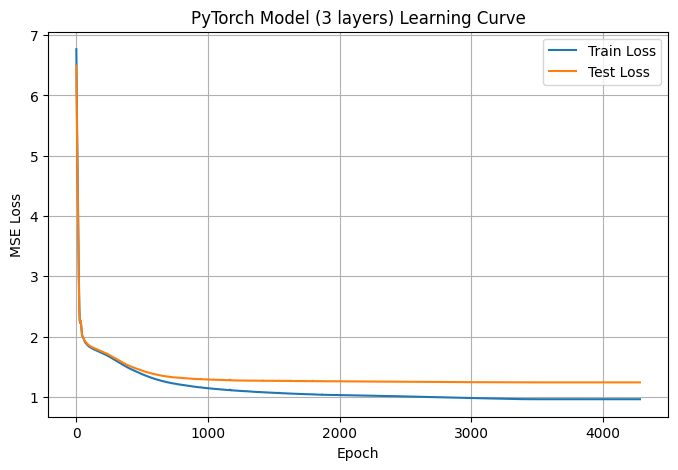

[PyTorch Model (3 layers) - Test Set]
MAE:  0.8395
RMSE: 1.1146
R²:   0.4854

[PyTorch Model (3 layers) - Training Set]
MAE:  0.7433
RMSE: 0.9814
R²:   0.6018


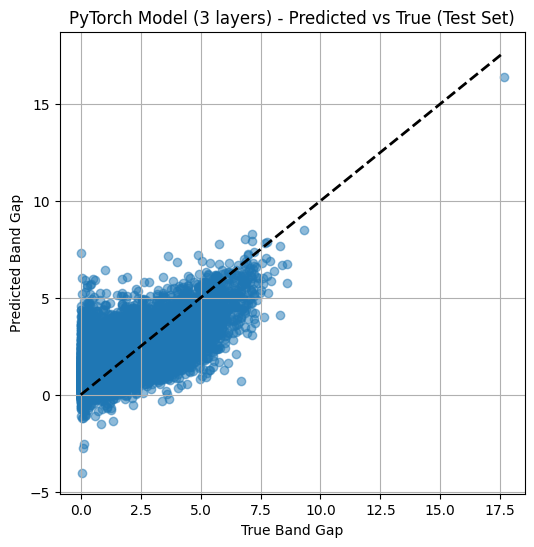

In [ ]:
# Make a metrics dictionary
model_layers3_metrics = evaluate_model(
    model_layers3,
    X_train_tensor,
    y_train,
    X_test_tensor,
    y_test
)
# Analyze the model
analyze_model(
    model_layers3_metrics,
    y_test,
    train_losses_layers3,
    test_losses_layers3,
    model_name="PyTorch Model (3 layers)"
)

## 6 Layers Network

In [ ]:
class DeepRegressor(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(  # Define the network layers
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.2), # Drops 20% of neurons randomly during training

            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2), # Drops 20% of neurons randomly during training

            nn.Linear(128, 64),
            nn.ReLU(),

            nn.Linear(64, 32),
            nn.ReLU(),

            nn.Linear(32, 16),
            nn.ReLU(),

            nn.Linear(16, 1)  # Output layer (no activation for regression)
        )

    def forward(self, x):
        return self.net(x)

# Initialize the model with the input dimension (number of features)
model_layers6 = DeepRegressor(X_train_tensor.shape[1])

In [ ]:

if torch.backends.mps.is_available():
    device = torch.device("mps")  # Use Metal GPU on Mac
elif torch.cuda.is_available():
    device = torch.device("cuda")  # Use NVIDIA GPU (not on Mac usually)
else:
    device = torch.device("cpu")  # Fallback

print("Using device:", device)

model_layers6.to(device)
X_train_tensor = X_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
X_test_tensor = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

print(X_train_tensor.device)
print(y_train_tensor.device)

Using device: mps
mps:0
mps:0


In [ ]:
model_layers6, train_losses_layers6, test_losses_layers6 = train_model(
    model_layers6,
    X_train_tensor,
    y_train_tensor,
    X_test_tensor,
    y_test_tensor,
    n_epochs=5000,
    lr=0.001,
    weight_decay=0,
    early_stop_patience=200,
    scheduler_patience=50,
    scheduler_factor=0.5,
    verbose_every=20
)

Training:   0%|          | 4/5000 [00:00<09:20,  8.91it/s]

Epoch    0 | Train Loss: 6.5042 | Test Loss: 6.4365


Training:   0%|          | 25/5000 [00:01<03:52, 21.44it/s]

Epoch   20 | Train Loss: 2.9352 | Test Loss: 2.6281


Training:   1%|          | 43/5000 [00:02<03:49, 21.60it/s]

Epoch   40 | Train Loss: 2.1342 | Test Loss: 2.0854


Training:   1%|▏         | 64/5000 [00:03<03:48, 21.60it/s]

Epoch   60 | Train Loss: 1.9674 | Test Loss: 1.9460


Training:   2%|▏         | 85/5000 [00:04<03:44, 21.93it/s]

Epoch   80 | Train Loss: 1.9000 | Test Loss: 1.8894


Training:   2%|▏         | 103/5000 [00:05<03:41, 22.09it/s]

Epoch  100 | Train Loss: 1.8633 | Test Loss: 1.8527


Training:   2%|▏         | 124/5000 [00:05<03:38, 22.27it/s]

Epoch  120 | Train Loss: 1.8265 | Test Loss: 1.8198


Training:   3%|▎         | 145/5000 [00:06<03:36, 22.40it/s]

Epoch  140 | Train Loss: 1.7977 | Test Loss: 1.7838


Training:   3%|▎         | 163/5000 [00:07<03:39, 22.02it/s]

Epoch  160 | Train Loss: 1.7632 | Test Loss: 1.7420


Training:   4%|▎         | 184/5000 [00:08<03:34, 22.42it/s]

Epoch  180 | Train Loss: 1.7252 | Test Loss: 1.6976


Training:   4%|▍         | 205/5000 [00:09<03:33, 22.43it/s]

Epoch  200 | Train Loss: 1.6868 | Test Loss: 1.6535


Training:   4%|▍         | 223/5000 [00:10<03:33, 22.42it/s]

Epoch  220 | Train Loss: 1.6535 | Test Loss: 1.6119


Training:   5%|▍         | 244/5000 [00:11<03:32, 22.37it/s]

Epoch  240 | Train Loss: 1.6121 | Test Loss: 1.5716


Training:   5%|▌         | 265/5000 [00:12<03:30, 22.44it/s]

Epoch  260 | Train Loss: 1.5705 | Test Loss: 1.5313


Training:   6%|▌         | 283/5000 [00:13<03:29, 22.49it/s]

Epoch  280 | Train Loss: 1.5453 | Test Loss: 1.4990


Training:   6%|▌         | 304/5000 [00:14<03:28, 22.56it/s]

Epoch  300 | Train Loss: 1.5101 | Test Loss: 1.4698


Training:   6%|▋         | 325/5000 [00:14<03:27, 22.48it/s]

Epoch  320 | Train Loss: 1.4798 | Test Loss: 1.4418


Training:   7%|▋         | 343/5000 [00:15<03:28, 22.28it/s]

Epoch  340 | Train Loss: 1.4525 | Test Loss: 1.4187


Training:   7%|▋         | 364/5000 [00:16<03:25, 22.55it/s]

Epoch  360 | Train Loss: 1.4270 | Test Loss: 1.3928


Training:   8%|▊         | 385/5000 [00:17<03:24, 22.55it/s]

Epoch  380 | Train Loss: 1.4020 | Test Loss: 1.3650


Training:   8%|▊         | 403/5000 [00:18<03:27, 22.18it/s]

Epoch  400 | Train Loss: 1.3828 | Test Loss: 1.3526


Training:   8%|▊         | 424/5000 [00:19<03:24, 22.35it/s]

Epoch  420 | Train Loss: 1.3661 | Test Loss: 1.3381


Training:   9%|▉         | 445/5000 [00:20<03:23, 22.35it/s]

Epoch  440 | Train Loss: 1.3579 | Test Loss: 1.3248


Training:   9%|▉         | 463/5000 [00:21<03:29, 21.62it/s]

Epoch  460 | Train Loss: 1.3396 | Test Loss: 1.3131


Training:  10%|▉         | 484/5000 [00:22<03:21, 22.37it/s]

Epoch  480 | Train Loss: 1.3242 | Test Loss: 1.3110


Training:  10%|█         | 505/5000 [00:23<03:20, 22.46it/s]

Epoch  500 | Train Loss: 1.3133 | Test Loss: 1.2911


Training:  10%|█         | 523/5000 [00:23<03:19, 22.49it/s]

Epoch  520 | Train Loss: 1.3014 | Test Loss: 1.2862


Training:  11%|█         | 544/5000 [00:24<03:18, 22.42it/s]

Epoch  540 | Train Loss: 1.2878 | Test Loss: 1.2697


Training:  11%|█▏        | 565/5000 [00:25<03:19, 22.22it/s]

Epoch  560 | Train Loss: 1.2749 | Test Loss: 1.2689


Training:  12%|█▏        | 583/5000 [00:26<03:17, 22.40it/s]

Epoch  580 | Train Loss: 1.2635 | Test Loss: 1.2570


Training:  12%|█▏        | 604/5000 [00:27<03:15, 22.54it/s]

Epoch  600 | Train Loss: 1.2553 | Test Loss: 1.2496


Training:  12%|█▎        | 625/5000 [00:28<03:14, 22.50it/s]

Epoch  620 | Train Loss: 1.2428 | Test Loss: 1.2403


Training:  13%|█▎        | 643/5000 [00:29<03:13, 22.47it/s]

Epoch  640 | Train Loss: 1.2284 | Test Loss: 1.2267


Training:  13%|█▎        | 664/5000 [00:30<03:12, 22.50it/s]

Epoch  660 | Train Loss: 1.2207 | Test Loss: 1.2194


Training:  14%|█▎        | 685/5000 [00:31<03:16, 22.01it/s]

Epoch  680 | Train Loss: 1.2125 | Test Loss: 1.2092


Training:  14%|█▍        | 703/5000 [00:31<03:13, 22.19it/s]

Epoch  700 | Train Loss: 1.1990 | Test Loss: 1.2025


Training:  14%|█▍        | 724/5000 [00:32<03:12, 22.27it/s]

Epoch  720 | Train Loss: 1.1896 | Test Loss: 1.2038


Training:  15%|█▍        | 745/5000 [00:33<03:09, 22.44it/s]

Epoch  740 | Train Loss: 1.1815 | Test Loss: 1.1927


Training:  15%|█▌        | 763/5000 [00:34<03:10, 22.30it/s]

Epoch  760 | Train Loss: 1.1662 | Test Loss: 1.1800


Training:  16%|█▌        | 784/5000 [00:35<03:09, 22.23it/s]

Epoch  780 | Train Loss: 1.1587 | Test Loss: 1.1725


Training:  16%|█▌        | 805/5000 [00:36<03:08, 22.20it/s]

Epoch  800 | Train Loss: 1.1461 | Test Loss: 1.1679


Training:  16%|█▋        | 823/5000 [00:37<03:06, 22.39it/s]

Epoch  820 | Train Loss: 1.1419 | Test Loss: 1.1618


Training:  17%|█▋        | 844/5000 [00:38<03:05, 22.44it/s]

Epoch  840 | Train Loss: 1.1259 | Test Loss: 1.1552


Training:  17%|█▋        | 865/5000 [00:39<03:04, 22.46it/s]

Epoch  860 | Train Loss: 1.1231 | Test Loss: 1.1546


Training:  18%|█▊        | 883/5000 [00:39<03:05, 22.18it/s]

Epoch  880 | Train Loss: 1.1174 | Test Loss: 1.1439


Training:  18%|█▊        | 904/5000 [00:40<03:02, 22.44it/s]

Epoch  900 | Train Loss: 1.1029 | Test Loss: 1.1405


Training:  18%|█▊        | 925/5000 [00:41<03:01, 22.49it/s]

Epoch  920 | Train Loss: 1.0915 | Test Loss: 1.1426


Training:  19%|█▉        | 943/5000 [00:42<02:59, 22.55it/s]

Epoch  940 | Train Loss: 1.0932 | Test Loss: 1.1337


Training:  19%|█▉        | 964/5000 [00:43<02:59, 22.52it/s]

Epoch  960 | Train Loss: 1.0830 | Test Loss: 1.1361


Training:  20%|█▉        | 985/5000 [00:44<02:58, 22.52it/s]

Epoch  980 | Train Loss: 1.0690 | Test Loss: 1.1242


Training:  20%|██        | 1003/5000 [00:45<02:57, 22.52it/s]

Epoch 1000 | Train Loss: 1.0755 | Test Loss: 1.1154


Training:  20%|██        | 1024/5000 [00:46<02:57, 22.46it/s]

Epoch 1020 | Train Loss: 1.0632 | Test Loss: 1.1147


Training:  21%|██        | 1045/5000 [00:47<02:56, 22.39it/s]

Epoch 1040 | Train Loss: 1.0501 | Test Loss: 1.1086


Training:  21%|██▏       | 1063/5000 [00:47<02:55, 22.46it/s]

Epoch 1060 | Train Loss: 1.0543 | Test Loss: 1.1073


Training:  22%|██▏       | 1084/5000 [00:48<02:55, 22.37it/s]

Epoch 1080 | Train Loss: 1.0435 | Test Loss: 1.1018


Training:  22%|██▏       | 1105/5000 [00:49<02:52, 22.53it/s]

Epoch 1100 | Train Loss: 1.0319 | Test Loss: 1.0914


Training:  22%|██▏       | 1123/5000 [00:50<02:52, 22.50it/s]

Epoch 1120 | Train Loss: 1.0255 | Test Loss: 1.0891


Training:  23%|██▎       | 1144/5000 [00:51<02:51, 22.52it/s]

Epoch 1140 | Train Loss: 1.0258 | Test Loss: 1.0888


Training:  23%|██▎       | 1165/5000 [00:52<02:50, 22.51it/s]

Epoch 1160 | Train Loss: 1.0172 | Test Loss: 1.0928


Training:  24%|██▎       | 1183/5000 [00:53<02:49, 22.52it/s]

Epoch 1180 | Train Loss: 1.0103 | Test Loss: 1.0891


Training:  24%|██▍       | 1204/5000 [00:54<02:50, 22.33it/s]

Epoch 1200 | Train Loss: 1.0008 | Test Loss: 1.0812


Training:  24%|██▍       | 1225/5000 [00:55<02:49, 22.28it/s]

Epoch 1220 | Train Loss: 0.9966 | Test Loss: 1.0823


Training:  25%|██▍       | 1243/5000 [00:56<02:49, 22.13it/s]

Epoch 1240 | Train Loss: 0.9946 | Test Loss: 1.0761


Training:  25%|██▌       | 1264/5000 [00:56<02:48, 22.17it/s]

Epoch 1260 | Train Loss: 0.9947 | Test Loss: 1.0745


Training:  26%|██▌       | 1285/5000 [00:57<02:46, 22.33it/s]

Epoch 1280 | Train Loss: 0.9823 | Test Loss: 1.0716


Training:  26%|██▌       | 1303/5000 [00:58<02:45, 22.31it/s]

Epoch 1300 | Train Loss: 0.9837 | Test Loss: 1.0679


Training:  26%|██▋       | 1324/5000 [00:59<02:44, 22.36it/s]

Epoch 1320 | Train Loss: 0.9796 | Test Loss: 1.0619


Training:  27%|██▋       | 1345/5000 [01:00<02:44, 22.25it/s]

Epoch 1340 | Train Loss: 0.9693 | Test Loss: 1.0650


Training:  27%|██▋       | 1363/5000 [01:01<02:42, 22.37it/s]

Epoch 1360 | Train Loss: 0.9623 | Test Loss: 1.0605


Training:  28%|██▊       | 1384/5000 [01:02<02:42, 22.21it/s]

Epoch 1380 | Train Loss: 0.9596 | Test Loss: 1.0647


Training:  28%|██▊       | 1405/5000 [01:03<02:40, 22.38it/s]

Epoch 1400 | Train Loss: 0.9559 | Test Loss: 1.0528


Training:  28%|██▊       | 1423/5000 [01:04<02:39, 22.42it/s]

Epoch 1420 | Train Loss: 0.9510 | Test Loss: 1.0512


Training:  29%|██▉       | 1444/5000 [01:05<02:39, 22.32it/s]

Epoch 1440 | Train Loss: 0.9486 | Test Loss: 1.0487


Training:  29%|██▉       | 1465/5000 [01:05<02:37, 22.38it/s]

Epoch 1460 | Train Loss: 0.9425 | Test Loss: 1.0502


Training:  30%|██▉       | 1483/5000 [01:06<02:45, 21.22it/s]

Epoch 1480 | Train Loss: 0.9401 | Test Loss: 1.0476


Training:  30%|███       | 1504/5000 [01:07<02:36, 22.32it/s]

Epoch 1500 | Train Loss: 0.9330 | Test Loss: 1.0503


Training:  30%|███       | 1525/5000 [01:08<02:34, 22.44it/s]

Epoch 1520 | Train Loss: 0.9290 | Test Loss: 1.0409


Training:  31%|███       | 1543/5000 [01:09<02:34, 22.44it/s]

Epoch 1540 | Train Loss: 0.9312 | Test Loss: 1.0492


Training:  31%|███▏      | 1564/5000 [01:10<02:33, 22.45it/s]

Epoch 1560 | Train Loss: 0.9171 | Test Loss: 1.0340


Training:  32%|███▏      | 1585/5000 [01:11<02:31, 22.54it/s]

Epoch 1580 | Train Loss: 0.9248 | Test Loss: 1.0357


Training:  32%|███▏      | 1603/5000 [01:12<02:30, 22.53it/s]

Epoch 1600 | Train Loss: 0.9177 | Test Loss: 1.0363


Training:  32%|███▏      | 1624/5000 [01:13<02:29, 22.57it/s]

Epoch 1620 | Train Loss: 0.9088 | Test Loss: 1.0336


Training:  33%|███▎      | 1645/5000 [01:14<02:29, 22.42it/s]

Epoch 1640 | Train Loss: 0.9015 | Test Loss: 1.0296


Training:  33%|███▎      | 1663/5000 [01:14<02:29, 22.37it/s]

Epoch 1660 | Train Loss: 0.9043 | Test Loss: 1.0303


Training:  34%|███▎      | 1684/5000 [01:15<02:31, 21.94it/s]

Epoch 1680 | Train Loss: 0.8940 | Test Loss: 1.0297


Training:  34%|███▍      | 1705/5000 [01:16<02:27, 22.39it/s]

Epoch 1700 | Train Loss: 0.8952 | Test Loss: 1.0291


Training:  34%|███▍      | 1723/5000 [01:17<02:25, 22.51it/s]

Epoch 1720 | Train Loss: 0.8983 | Test Loss: 1.0260


Training:  35%|███▍      | 1744/5000 [01:18<02:25, 22.43it/s]

Epoch 1740 | Train Loss: 0.8931 | Test Loss: 1.0269


Training:  35%|███▌      | 1765/5000 [01:19<02:25, 22.30it/s]

Epoch 1760 | Train Loss: 0.8896 | Test Loss: 1.0231


Training:  36%|███▌      | 1783/5000 [01:20<02:24, 22.34it/s]

Epoch 1780 | Train Loss: 0.8842 | Test Loss: 1.0239


Training:  36%|███▌      | 1804/5000 [01:21<02:22, 22.43it/s]

Epoch 1800 | Train Loss: 0.8931 | Test Loss: 1.0219


Training:  36%|███▋      | 1825/5000 [01:22<02:21, 22.51it/s]

Epoch 1820 | Train Loss: 0.8856 | Test Loss: 1.0229


Training:  37%|███▋      | 1843/5000 [01:22<02:19, 22.60it/s]

Epoch 1840 | Train Loss: 0.8892 | Test Loss: 1.0225


Training:  37%|███▋      | 1864/5000 [01:23<02:22, 21.99it/s]

Epoch 1860 | Train Loss: 0.8848 | Test Loss: 1.0220


Training:  38%|███▊      | 1885/5000 [01:24<02:18, 22.44it/s]

Epoch 1880 | Train Loss: 0.8846 | Test Loss: 1.0232


Training:  38%|███▊      | 1903/5000 [01:25<02:17, 22.45it/s]

Epoch 1900 | Train Loss: 0.8815 | Test Loss: 1.0235


Training:  38%|███▊      | 1924/5000 [01:26<02:17, 22.33it/s]

Epoch 1920 | Train Loss: 0.8796 | Test Loss: 1.0218


Training:  39%|███▉      | 1945/5000 [01:27<02:16, 22.33it/s]

Epoch 1940 | Train Loss: 0.8793 | Test Loss: 1.0218


Training:  39%|███▉      | 1949/5000 [01:27<02:17, 22.22it/s]


⏹️ Early stopping at epoch 1949

✅ Training completed in 87.71 seconds (1.46 minutes)


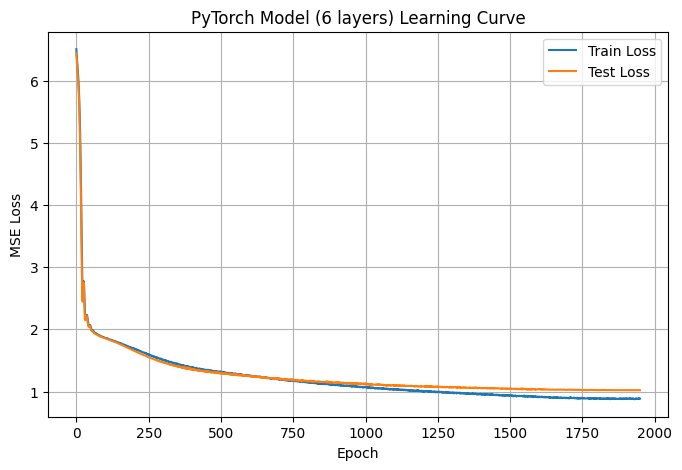

[PyTorch Model (6 layers) - Test Set]
MAE:  0.7517
RMSE: 1.0106
R²:   0.5769

[PyTorch Model (6 layers) - Training Set]
MAE:  0.6409
RMSE: 0.8396
R²:   0.7086


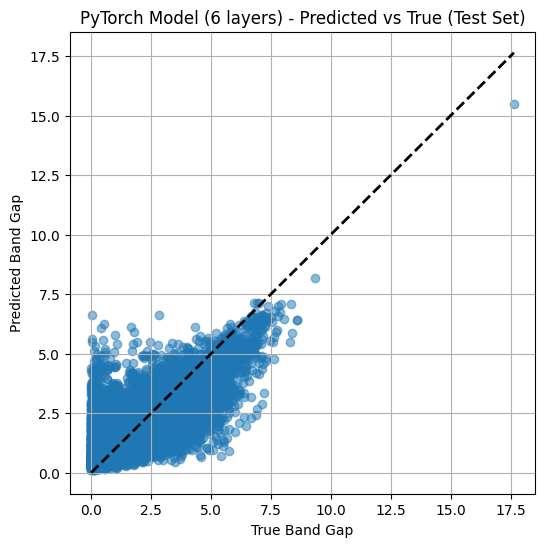

In [ ]:
# Make a metrics dictionary
model_layers6_metrics = evaluate_model(
    model_layers6,
    X_train_tensor,
    y_train,
    X_test_tensor,
    y_test
)
# Analyze the model
analyze_model(
    model_layers6_metrics,
    y_test,
    train_losses_layers6,
    test_losses_layers6,
    model_name="PyTorch Model (6 layers)"
)

## 10 Layers Network

In [ ]:
import torch.nn as nn

class DeepRegressor(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 512),  # Layer 1
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(512, 384),        # Layer 2
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(384, 256),        # Layer 3
            nn.ReLU(),
            nn.Dropout(0.25),

            nn.Linear(256, 192),        # Layer 4
            nn.ReLU(),

            nn.Linear(192, 128),        # Layer 5
            nn.ReLU(),

            nn.Linear(128, 96),         # Layer 6
            nn.ReLU(),

            nn.Linear(96, 64),          # Layer 7
            nn.ReLU(),

            nn.Linear(64, 48),          # Layer 8
            nn.ReLU(),

            nn.Linear(48, 32),          # Layer 9
            nn.ReLU(),

            nn.Linear(32, 1)            # Layer 10 (Output)
        )

    def forward(self, x):
        return self.net(x)

# Initialize the model
model_layers10 = DeepRegressor(X_train_tensor.shape[1])


In [ ]:
if torch.backends.mps.is_available():
    device = torch.device("mps")  # Use Metal GPU on Mac
elif torch.cuda.is_available():
    device = torch.device("cuda")  # Use NVIDIA GPU (not on Mac usually)
else:
    device = torch.device("cpu")  # Fallback

print("Using device:", device)

model_layers10.to(device)
X_train_tensor = X_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
X_test_tensor = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

print(X_train_tensor.device)
print(y_train_tensor.device)

Using device: mps
mps:0
mps:0


In [ ]:
model_layers10, train_losses_layers10, test_losses_layers10 = train_model(
    model_layers10,
    X_train_tensor,
    y_train_tensor,
    X_test_tensor,
    y_test_tensor,
    n_epochs=5000,
    lr=0.001,
    weight_decay=0,
    early_stop_patience=200,
    scheduler_patience=50,
    scheduler_factor=0.5,
    verbose_every=20
)

Training:   0%|          | 1/5000 [00:00<52:04,  1.60it/s]

Epoch    0 | Train Loss: 6.0317 | Test Loss: 5.9959


Training:   0%|          | 21/5000 [00:05<18:32,  4.48it/s]

Epoch   20 | Train Loss: 2.3643 | Test Loss: 2.1828


Training:   1%|          | 41/5000 [00:09<18:08,  4.56it/s]

Epoch   40 | Train Loss: 2.0190 | Test Loss: 2.0020


Training:   1%|          | 61/5000 [00:13<18:13,  4.51it/s]

Epoch   60 | Train Loss: 1.8854 | Test Loss: 1.8777


Training:   2%|▏         | 81/5000 [00:18<18:21,  4.47it/s]

Epoch   80 | Train Loss: 1.8246 | Test Loss: 1.8137


Training:   2%|▏         | 101/5000 [00:22<18:07,  4.50it/s]

Epoch  100 | Train Loss: 1.7766 | Test Loss: 1.7569


Training:   2%|▏         | 121/5000 [00:27<18:05,  4.50it/s]

Epoch  120 | Train Loss: 1.7193 | Test Loss: 1.6888


Training:   3%|▎         | 141/5000 [00:31<17:55,  4.52it/s]

Epoch  140 | Train Loss: 1.6546 | Test Loss: 1.6102


Training:   3%|▎         | 161/5000 [00:36<17:52,  4.51it/s]

Epoch  160 | Train Loss: 1.6029 | Test Loss: 1.5567


Training:   4%|▎         | 181/5000 [00:40<17:49,  4.51it/s]

Epoch  180 | Train Loss: 1.5633 | Test Loss: 1.5221


Training:   4%|▍         | 201/5000 [00:45<17:43,  4.51it/s]

Epoch  200 | Train Loss: 1.5198 | Test Loss: 1.4771


Training:   4%|▍         | 221/5000 [00:49<17:40,  4.51it/s]

Epoch  220 | Train Loss: 1.4893 | Test Loss: 1.4456


Training:   5%|▍         | 241/5000 [00:53<17:47,  4.46it/s]

Epoch  240 | Train Loss: 1.4628 | Test Loss: 1.4256


Training:   5%|▌         | 261/5000 [00:58<17:32,  4.50it/s]

Epoch  260 | Train Loss: 1.4201 | Test Loss: 1.4054


Training:   6%|▌         | 281/5000 [01:02<17:28,  4.50it/s]

Epoch  280 | Train Loss: 1.3998 | Test Loss: 1.3608


Training:   6%|▌         | 301/5000 [01:07<17:39,  4.44it/s]

Epoch  300 | Train Loss: 1.3888 | Test Loss: 1.3454


Training:   6%|▋         | 321/5000 [01:11<17:17,  4.51it/s]

Epoch  320 | Train Loss: 1.3509 | Test Loss: 1.3454


Training:   7%|▋         | 341/5000 [01:16<17:09,  4.53it/s]

Epoch  340 | Train Loss: 1.3310 | Test Loss: 1.3311


Training:   7%|▋         | 361/5000 [01:20<17:12,  4.49it/s]

Epoch  360 | Train Loss: 1.3258 | Test Loss: 1.3425


Training:   8%|▊         | 381/5000 [01:24<17:04,  4.51it/s]

Epoch  380 | Train Loss: 1.3003 | Test Loss: 1.2879


Training:   8%|▊         | 401/5000 [01:29<17:03,  4.49it/s]

Epoch  400 | Train Loss: 1.2749 | Test Loss: 1.2812


Training:   8%|▊         | 421/5000 [01:33<16:59,  4.49it/s]

Epoch  420 | Train Loss: 1.2607 | Test Loss: 1.2955


Training:   9%|▉         | 441/5000 [01:38<16:50,  4.51it/s]

Epoch  440 | Train Loss: 1.2456 | Test Loss: 1.2776


Training:   9%|▉         | 461/5000 [01:42<16:42,  4.53it/s]

Epoch  460 | Train Loss: 1.2286 | Test Loss: 1.2742


Training:  10%|▉         | 481/5000 [01:47<16:42,  4.51it/s]

Epoch  480 | Train Loss: 1.2119 | Test Loss: 1.2553


Training:  10%|█         | 501/5000 [01:51<16:37,  4.51it/s]

Epoch  500 | Train Loss: 1.1926 | Test Loss: 1.2242


Training:  10%|█         | 521/5000 [01:55<16:32,  4.51it/s]

Epoch  520 | Train Loss: 1.1767 | Test Loss: 1.2173


Training:  11%|█         | 541/5000 [02:00<16:30,  4.50it/s]

Epoch  540 | Train Loss: 1.1579 | Test Loss: 1.2111


Training:  11%|█         | 561/5000 [02:04<16:25,  4.50it/s]

Epoch  560 | Train Loss: 1.1429 | Test Loss: 1.1858


Training:  12%|█▏        | 581/5000 [02:09<16:22,  4.50it/s]

Epoch  580 | Train Loss: 1.1350 | Test Loss: 1.1987


Training:  12%|█▏        | 601/5000 [02:13<16:23,  4.47it/s]

Epoch  600 | Train Loss: 1.1200 | Test Loss: 1.1813


Training:  12%|█▏        | 621/5000 [02:18<16:12,  4.50it/s]

Epoch  620 | Train Loss: 1.1071 | Test Loss: 1.1795


Training:  13%|█▎        | 641/5000 [02:22<16:08,  4.50it/s]

Epoch  640 | Train Loss: 1.0792 | Test Loss: 1.1673


Training:  13%|█▎        | 661/5000 [02:26<15:59,  4.52it/s]

Epoch  660 | Train Loss: 1.0721 | Test Loss: 1.1412


Training:  14%|█▎        | 681/5000 [02:31<15:50,  4.54it/s]

Epoch  680 | Train Loss: 1.0631 | Test Loss: 1.1294


Training:  14%|█▍        | 701/5000 [02:35<15:59,  4.48it/s]

Epoch  700 | Train Loss: 1.0374 | Test Loss: 1.1639


Training:  14%|█▍        | 721/5000 [02:40<15:40,  4.55it/s]

Epoch  720 | Train Loss: 1.0286 | Test Loss: 1.1130


Training:  15%|█▍        | 741/5000 [02:44<15:42,  4.52it/s]

Epoch  740 | Train Loss: 1.0117 | Test Loss: 1.1018


Training:  15%|█▌        | 761/5000 [02:49<15:40,  4.51it/s]

Epoch  760 | Train Loss: 0.9944 | Test Loss: 1.1229


Training:  16%|█▌        | 781/5000 [02:53<15:32,  4.52it/s]

Epoch  780 | Train Loss: 0.9799 | Test Loss: 1.1095


Training:  16%|█▌        | 801/5000 [02:57<15:28,  4.52it/s]

Epoch  800 | Train Loss: 0.9685 | Test Loss: 1.0937


Training:  16%|█▋        | 821/5000 [03:02<15:20,  4.54it/s]

Epoch  820 | Train Loss: 0.9578 | Test Loss: 1.0863


Training:  17%|█▋        | 841/5000 [03:06<15:15,  4.54it/s]

Epoch  840 | Train Loss: 0.9485 | Test Loss: 1.0760


Training:  17%|█▋        | 861/5000 [03:11<15:22,  4.49it/s]

Epoch  860 | Train Loss: 0.9330 | Test Loss: 1.0899


Training:  18%|█▊        | 881/5000 [03:15<15:16,  4.49it/s]

Epoch  880 | Train Loss: 0.9204 | Test Loss: 1.0669


Training:  18%|█▊        | 901/5000 [03:20<15:19,  4.46it/s]

Epoch  900 | Train Loss: 0.9146 | Test Loss: 1.1008


Training:  18%|█▊        | 921/5000 [03:24<15:02,  4.52it/s]

Epoch  920 | Train Loss: 0.9058 | Test Loss: 1.0791


Training:  19%|█▉        | 941/5000 [03:28<15:00,  4.51it/s]

Epoch  940 | Train Loss: 0.8903 | Test Loss: 1.0475


Training:  19%|█▉        | 961/5000 [03:33<14:58,  4.50it/s]

Epoch  960 | Train Loss: 0.8704 | Test Loss: 1.0573


Training:  20%|█▉        | 981/5000 [03:37<14:52,  4.50it/s]

Epoch  980 | Train Loss: 0.8575 | Test Loss: 1.0441


Training:  20%|██        | 1001/5000 [03:42<14:46,  4.51it/s]

Epoch 1000 | Train Loss: 0.8522 | Test Loss: 1.0438


Training:  20%|██        | 1021/5000 [03:46<14:48,  4.48it/s]

Epoch 1020 | Train Loss: 0.8437 | Test Loss: 1.0528


Training:  21%|██        | 1041/5000 [03:51<14:35,  4.52it/s]

Epoch 1040 | Train Loss: 0.8359 | Test Loss: 1.0531


Training:  21%|██        | 1061/5000 [03:55<14:35,  4.50it/s]

Epoch 1060 | Train Loss: 0.8229 | Test Loss: 1.0431


Training:  22%|██▏       | 1081/5000 [04:00<14:27,  4.52it/s]

Epoch 1080 | Train Loss: 0.8118 | Test Loss: 1.0317


Training:  22%|██▏       | 1101/5000 [04:04<14:28,  4.49it/s]

Epoch 1100 | Train Loss: 0.8099 | Test Loss: 1.0423


Training:  22%|██▏       | 1121/5000 [04:08<14:19,  4.52it/s]

Epoch 1120 | Train Loss: 0.8010 | Test Loss: 1.0291


Training:  23%|██▎       | 1141/5000 [04:13<14:31,  4.43it/s]

Epoch 1140 | Train Loss: 0.7898 | Test Loss: 1.0439


Training:  23%|██▎       | 1161/5000 [04:17<14:15,  4.49it/s]

Epoch 1160 | Train Loss: 0.7723 | Test Loss: 1.0216


Training:  24%|██▎       | 1181/5000 [04:22<14:15,  4.47it/s]

Epoch 1180 | Train Loss: 0.7735 | Test Loss: 1.0265


Training:  24%|██▍       | 1201/5000 [04:26<13:58,  4.53it/s]

Epoch 1200 | Train Loss: 0.7639 | Test Loss: 1.0119


Training:  24%|██▍       | 1221/5000 [04:31<13:54,  4.53it/s]

Epoch 1220 | Train Loss: 0.7608 | Test Loss: 1.0186


Training:  25%|██▍       | 1241/5000 [04:35<13:58,  4.48it/s]

Epoch 1240 | Train Loss: 0.7591 | Test Loss: 1.0096


Training:  25%|██▌       | 1261/5000 [04:39<13:45,  4.53it/s]

Epoch 1260 | Train Loss: 0.7513 | Test Loss: 1.0163


Training:  26%|██▌       | 1281/5000 [04:44<13:42,  4.52it/s]

Epoch 1280 | Train Loss: 0.7496 | Test Loss: 1.0228


Training:  26%|██▌       | 1301/5000 [04:48<13:37,  4.53it/s]

Epoch 1300 | Train Loss: 0.7442 | Test Loss: 1.0138


Training:  26%|██▋       | 1321/5000 [04:53<13:37,  4.50it/s]

Epoch 1320 | Train Loss: 0.7391 | Test Loss: 1.0110


Training:  27%|██▋       | 1341/5000 [04:57<13:30,  4.51it/s]

Epoch 1340 | Train Loss: 0.7403 | Test Loss: 1.0145


Training:  27%|██▋       | 1361/5000 [05:02<13:28,  4.50it/s]

Epoch 1360 | Train Loss: 0.7296 | Test Loss: 1.0136


Training:  28%|██▊       | 1381/5000 [05:06<13:24,  4.50it/s]

Epoch 1380 | Train Loss: 0.7390 | Test Loss: 1.0083


Training:  28%|██▊       | 1401/5000 [05:11<13:23,  4.48it/s]

Epoch 1400 | Train Loss: 0.7265 | Test Loss: 1.0077


Training:  28%|██▊       | 1421/5000 [05:15<13:18,  4.48it/s]

Epoch 1420 | Train Loss: 0.7252 | Test Loss: 1.0078


Training:  29%|██▉       | 1441/5000 [05:19<13:07,  4.52it/s]

Epoch 1440 | Train Loss: 0.7152 | Test Loss: 1.0017


Training:  29%|██▉       | 1461/5000 [05:24<13:16,  4.45it/s]

Epoch 1460 | Train Loss: 0.7160 | Test Loss: 1.0062


Training:  30%|██▉       | 1481/5000 [05:28<13:04,  4.48it/s]

Epoch 1480 | Train Loss: 0.7117 | Test Loss: 1.0017


Training:  30%|███       | 1501/5000 [05:33<12:54,  4.52it/s]

Epoch 1500 | Train Loss: 0.7134 | Test Loss: 1.0018


Training:  30%|███       | 1521/5000 [05:37<12:47,  4.53it/s]

Epoch 1520 | Train Loss: 0.7113 | Test Loss: 1.0040


Training:  31%|███       | 1534/5000 [05:40<12:50,  4.50it/s]


⏹️ Early stopping at epoch 1534

✅ Training completed in 340.81 seconds (5.68 minutes)


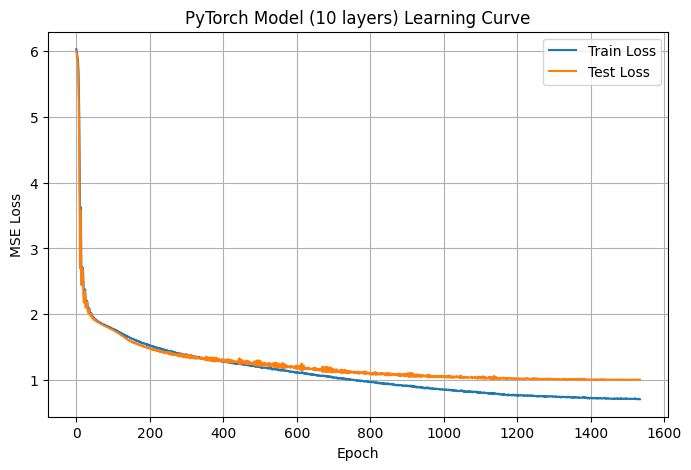

[PyTorch Model (10 layers) - Test Set]
MAE:  0.7232
RMSE: 1.0013
R²:   0.5846

[PyTorch Model (10 layers) - Training Set]
MAE:  0.5360
RMSE: 0.7024
R²:   0.7960


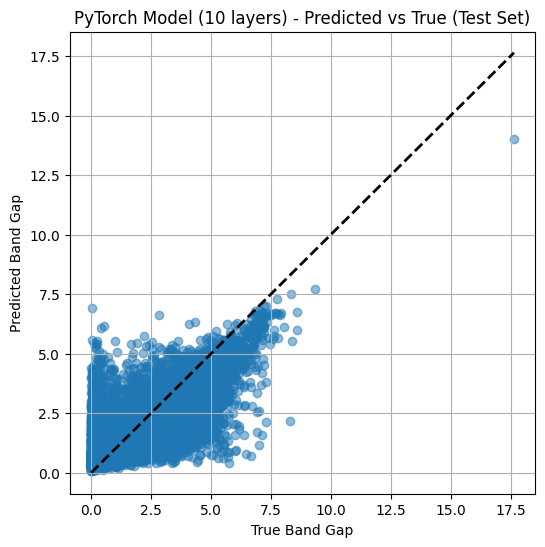

In [ ]:
# Evaluate model
# Make a metrics dictionary
model_layers10_metrics = evaluate_model(
    model_layers10,
    X_train_tensor,
    y_train,
    X_test_tensor,
    y_test
)
# Analyze the model
analyze_model(
    model_layers10_metrics,
    y_test,
    train_losses_layers10,
    test_losses_layers10,
    model_name="PyTorch Model (10 layers)"
)


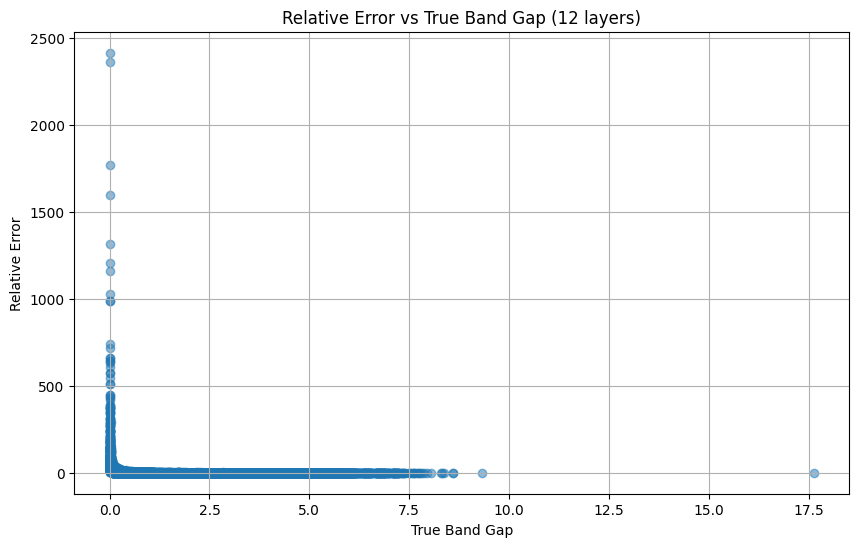

In [ ]:
# relative error vs true band gap plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, np.abs(model_layers10_metrics['test']['y_pred_test'].flatten() - y_test) / y_test, alpha=0.5)
plt.xlabel("True Band Gap")
plt.ylabel("Relative Error")
plt.title("Relative Error vs True Band Gap (12 layers)")
plt.grid(True)
plt.show()

## 12 Layers Network

In [ ]:
import torch.nn as nn

class DeepRegressor(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 768),   # Layer 1
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(768, 512),         # Layer 2
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(512, 384),         # Layer 3
            nn.ReLU(),

            nn.Linear(384, 256),         # Layer 4
            nn.ReLU(),
            nn.Dropout(0.25),

            nn.Linear(256, 192),         # Layer 5
            nn.ReLU(),

            nn.Linear(192, 128),         # Layer 6
            nn.ReLU(),

            nn.Linear(128, 96),          # Layer 7
            nn.ReLU(),

            nn.Linear(96, 72),           # Layer 8
            nn.ReLU(),

            nn.Linear(72, 48),           # Layer 9
            nn.ReLU(),

            nn.Linear(48, 32),           # Layer 10
            nn.ReLU(),

            nn.Linear(32, 16),           # Layer 11
            nn.ReLU(),

            nn.Linear(16, 1)             # Layer 12 (Output)
        )

    def forward(self, x):
        return self.net(x)

# Initialize the 12-layer model
model_layers12 = DeepRegressor(X_train_tensor.shape[1])


In [ ]:
if torch.backends.mps.is_available():
    device = torch.device("mps")  # Use Metal GPU on Mac
elif torch.cuda.is_available():
    device = torch.device("cuda")  # Use NVIDIA GPU (not on Mac usually)
else:
    device = torch.device("cpu")  # Fallback

print("Using device:", device)

model_layers12.to(device)
X_train_tensor = X_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
X_test_tensor = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

print(X_train_tensor.device)
print(y_train_tensor.device)

Using device: mps
mps:0
mps:0


In [ ]:
model_layers12, train_losses_layers12, test_losses_layers12 = train_model(
    model_layers12,
    X_train_tensor,
    y_train_tensor,
    X_test_tensor,
    y_test_tensor,
    n_epochs=5000,
    lr=0.001,
    weight_decay=0, # L2 regularization
    early_stop_patience=200,
    scheduler_patience=50,
    scheduler_factor=0.5,
    verbose_every=20
)

Training:   0%|          | 1/5000 [00:01<1:40:02,  1.20s/it]

Epoch    0 | Train Loss: 6.3997 | Test Loss: 6.3666


Training:   0%|          | 21/5000 [00:09<33:35,  2.47it/s] 

Epoch   20 | Train Loss: 2.5115 | Test Loss: 2.6089


Training:   1%|          | 41/5000 [00:17<33:36,  2.46it/s]

Epoch   40 | Train Loss: 2.0307 | Test Loss: 2.0373


Training:   1%|          | 61/5000 [00:25<33:22,  2.47it/s]

Epoch   60 | Train Loss: 1.9169 | Test Loss: 1.9017


Training:   2%|▏         | 81/5000 [00:33<33:13,  2.47it/s]

Epoch   80 | Train Loss: 1.8506 | Test Loss: 1.8393


Training:   2%|▏         | 101/5000 [00:41<33:05,  2.47it/s]

Epoch  100 | Train Loss: 1.7990 | Test Loss: 1.7856


Training:   2%|▏         | 121/5000 [00:49<33:06,  2.46it/s]

Epoch  120 | Train Loss: 1.7445 | Test Loss: 1.7301


Training:   3%|▎         | 141/5000 [00:58<32:52,  2.46it/s]

Epoch  140 | Train Loss: 1.6995 | Test Loss: 1.6759


Training:   3%|▎         | 161/5000 [01:06<32:51,  2.45it/s]

Epoch  160 | Train Loss: 1.6555 | Test Loss: 1.6241


Training:   4%|▎         | 181/5000 [01:14<32:39,  2.46it/s]

Epoch  180 | Train Loss: 1.6113 | Test Loss: 1.5776


Training:   4%|▍         | 201/5000 [01:22<32:45,  2.44it/s]

Epoch  200 | Train Loss: 1.5725 | Test Loss: 1.5363


Training:   4%|▍         | 221/5000 [01:30<32:37,  2.44it/s]

Epoch  220 | Train Loss: 1.5304 | Test Loss: 1.4921


Training:   5%|▍         | 241/5000 [01:38<32:21,  2.45it/s]

Epoch  240 | Train Loss: 1.4969 | Test Loss: 1.4637


Training:   5%|▌         | 261/5000 [01:47<32:27,  2.43it/s]

Epoch  260 | Train Loss: 1.4638 | Test Loss: 1.4268


Training:   6%|▌         | 281/5000 [01:55<32:27,  2.42it/s]

Epoch  280 | Train Loss: 1.4398 | Test Loss: 1.3992


Training:   6%|▌         | 301/5000 [02:03<32:06,  2.44it/s]

Epoch  300 | Train Loss: 1.4067 | Test Loss: 1.3777


Training:   6%|▋         | 321/5000 [02:11<32:44,  2.38it/s]

Epoch  320 | Train Loss: 1.3832 | Test Loss: 1.3630


Training:   7%|▋         | 341/5000 [02:20<31:40,  2.45it/s]

Epoch  340 | Train Loss: 1.3910 | Test Loss: 1.3655


Training:   7%|▋         | 361/5000 [02:28<32:12,  2.40it/s]

Epoch  360 | Train Loss: 1.3489 | Test Loss: 1.3492


Training:   8%|▊         | 381/5000 [02:36<31:57,  2.41it/s]

Epoch  380 | Train Loss: 1.3317 | Test Loss: 1.3240


Training:   8%|▊         | 401/5000 [02:45<31:38,  2.42it/s]

Epoch  400 | Train Loss: 1.3174 | Test Loss: 1.3039


Training:   8%|▊         | 421/5000 [02:53<31:15,  2.44it/s]

Epoch  420 | Train Loss: 1.3039 | Test Loss: 1.3062


Training:   9%|▉         | 441/5000 [03:01<31:26,  2.42it/s]

Epoch  440 | Train Loss: 1.2892 | Test Loss: 1.2992


Training:   9%|▉         | 461/5000 [03:09<31:33,  2.40it/s]

Epoch  460 | Train Loss: 1.2671 | Test Loss: 1.2991


Training:  10%|▉         | 481/5000 [03:18<30:55,  2.44it/s]

Epoch  480 | Train Loss: 1.2643 | Test Loss: 1.2956


Training:  10%|█         | 501/5000 [03:26<31:12,  2.40it/s]

Epoch  500 | Train Loss: 1.2502 | Test Loss: 1.2362


Training:  10%|█         | 521/5000 [03:34<30:35,  2.44it/s]

Epoch  520 | Train Loss: 1.2232 | Test Loss: 1.2446


Training:  11%|█         | 541/5000 [03:42<30:20,  2.45it/s]

Epoch  540 | Train Loss: 1.2080 | Test Loss: 1.2644


Training:  11%|█         | 561/5000 [03:51<30:04,  2.46it/s]

Epoch  560 | Train Loss: 1.1902 | Test Loss: 1.2255


Training:  12%|█▏        | 581/5000 [03:59<29:55,  2.46it/s]

Epoch  580 | Train Loss: 1.1777 | Test Loss: 1.2065


Training:  12%|█▏        | 601/5000 [04:07<29:50,  2.46it/s]

Epoch  600 | Train Loss: 1.1692 | Test Loss: 1.2565


Training:  12%|█▏        | 621/5000 [04:15<29:44,  2.45it/s]

Epoch  620 | Train Loss: 1.1509 | Test Loss: 1.2473


Training:  13%|█▎        | 641/5000 [04:23<29:49,  2.44it/s]

Epoch  640 | Train Loss: 1.1441 | Test Loss: 1.2040


Training:  13%|█▎        | 661/5000 [04:32<30:58,  2.33it/s]

Epoch  660 | Train Loss: 1.1266 | Test Loss: 1.1724


Training:  14%|█▎        | 681/5000 [04:40<29:17,  2.46it/s]

Epoch  680 | Train Loss: 1.1135 | Test Loss: 1.2108


Training:  14%|█▍        | 701/5000 [04:48<29:05,  2.46it/s]

Epoch  700 | Train Loss: 1.1134 | Test Loss: 1.2773


Training:  14%|█▍        | 721/5000 [04:56<28:49,  2.47it/s]

Epoch  720 | Train Loss: 1.0735 | Test Loss: 1.1996


Training:  15%|█▍        | 741/5000 [05:04<28:48,  2.46it/s]

Epoch  740 | Train Loss: 1.0649 | Test Loss: 1.1613


Training:  15%|█▌        | 761/5000 [05:12<28:45,  2.46it/s]

Epoch  760 | Train Loss: 1.0429 | Test Loss: 1.1535


Training:  16%|█▌        | 781/5000 [05:21<28:41,  2.45it/s]

Epoch  780 | Train Loss: 1.0389 | Test Loss: 1.1379


Training:  16%|█▌        | 801/5000 [05:29<28:30,  2.45it/s]

Epoch  800 | Train Loss: 1.0303 | Test Loss: 1.1396


Training:  16%|█▋        | 821/5000 [05:37<28:08,  2.48it/s]

Epoch  820 | Train Loss: 1.0233 | Test Loss: 1.1436


Training:  17%|█▋        | 841/5000 [05:45<28:00,  2.47it/s]

Epoch  840 | Train Loss: 1.0067 | Test Loss: 1.1441


Training:  17%|█▋        | 861/5000 [05:53<28:07,  2.45it/s]

Epoch  860 | Train Loss: 1.0010 | Test Loss: 1.1394


Training:  18%|█▊        | 881/5000 [06:01<27:57,  2.46it/s]

Epoch  880 | Train Loss: 0.9991 | Test Loss: 1.1355


Training:  18%|█▊        | 901/5000 [06:09<27:47,  2.46it/s]

Epoch  900 | Train Loss: 0.9894 | Test Loss: 1.1311


Training:  18%|█▊        | 921/5000 [06:17<27:36,  2.46it/s]

Epoch  920 | Train Loss: 0.9852 | Test Loss: 1.1327


Training:  19%|█▉        | 941/5000 [06:26<27:31,  2.46it/s]

Epoch  940 | Train Loss: 0.9868 | Test Loss: 1.1247


Training:  19%|█▉        | 961/5000 [06:34<27:33,  2.44it/s]

Epoch  960 | Train Loss: 0.9759 | Test Loss: 1.1190


Training:  20%|█▉        | 981/5000 [06:42<27:15,  2.46it/s]

Epoch  980 | Train Loss: 0.9628 | Test Loss: 1.1232


Training:  20%|██        | 1001/5000 [06:50<26:59,  2.47it/s]

Epoch 1000 | Train Loss: 0.9613 | Test Loss: 1.1094


Training:  20%|██        | 1021/5000 [06:58<26:56,  2.46it/s]

Epoch 1020 | Train Loss: 0.9566 | Test Loss: 1.1117


Training:  21%|██        | 1041/5000 [07:06<26:43,  2.47it/s]

Epoch 1040 | Train Loss: 0.9554 | Test Loss: 1.1133


Training:  21%|██        | 1061/5000 [07:14<26:34,  2.47it/s]

Epoch 1060 | Train Loss: 0.9480 | Test Loss: 1.1083


Training:  22%|██▏       | 1081/5000 [07:22<26:26,  2.47it/s]

Epoch 1080 | Train Loss: 0.9422 | Test Loss: 1.0996


Training:  22%|██▏       | 1101/5000 [07:31<26:27,  2.46it/s]

Epoch 1100 | Train Loss: 0.9318 | Test Loss: 1.0999


Training:  22%|██▏       | 1121/5000 [07:39<26:08,  2.47it/s]

Epoch 1120 | Train Loss: 0.9271 | Test Loss: 1.0966


Training:  23%|██▎       | 1141/5000 [07:47<26:01,  2.47it/s]

Epoch 1140 | Train Loss: 0.9245 | Test Loss: 1.0921


Training:  23%|██▎       | 1161/5000 [07:55<25:58,  2.46it/s]

Epoch 1160 | Train Loss: 0.9139 | Test Loss: 1.1013


Training:  24%|██▎       | 1181/5000 [08:03<25:58,  2.45it/s]

Epoch 1180 | Train Loss: 0.9128 | Test Loss: 1.1004


Training:  24%|██▍       | 1201/5000 [08:11<25:31,  2.48it/s]

Epoch 1200 | Train Loss: 0.9054 | Test Loss: 1.0948


Training:  24%|██▍       | 1221/5000 [08:19<25:31,  2.47it/s]

Epoch 1220 | Train Loss: 0.8912 | Test Loss: 1.0892


Training:  25%|██▍       | 1241/5000 [08:27<25:17,  2.48it/s]

Epoch 1240 | Train Loss: 0.8876 | Test Loss: 1.0962


Training:  25%|██▌       | 1261/5000 [08:36<25:23,  2.45it/s]

Epoch 1260 | Train Loss: 0.8801 | Test Loss: 1.0790


Training:  26%|██▌       | 1281/5000 [08:44<25:37,  2.42it/s]

Epoch 1280 | Train Loss: 0.8685 | Test Loss: 1.0815


Training:  26%|██▌       | 1301/5000 [08:52<25:05,  2.46it/s]

Epoch 1300 | Train Loss: 0.8616 | Test Loss: 1.0734


Training:  26%|██▋       | 1321/5000 [09:00<24:57,  2.46it/s]

Epoch 1320 | Train Loss: 0.8656 | Test Loss: 1.0708


Training:  27%|██▋       | 1341/5000 [09:08<24:48,  2.46it/s]

Epoch 1340 | Train Loss: 0.8448 | Test Loss: 1.0643


Training:  27%|██▋       | 1361/5000 [09:16<24:41,  2.46it/s]

Epoch 1360 | Train Loss: 0.8446 | Test Loss: 1.0635


Training:  28%|██▊       | 1381/5000 [09:24<24:32,  2.46it/s]

Epoch 1380 | Train Loss: 0.8387 | Test Loss: 1.0693


Training:  28%|██▊       | 1401/5000 [09:33<24:27,  2.45it/s]

Epoch 1400 | Train Loss: 0.8342 | Test Loss: 1.0674


Training:  28%|██▊       | 1421/5000 [09:41<24:17,  2.45it/s]

Epoch 1420 | Train Loss: 0.8293 | Test Loss: 1.0527


Training:  29%|██▉       | 1441/5000 [09:49<24:10,  2.45it/s]

Epoch 1440 | Train Loss: 0.8175 | Test Loss: 1.0565


Training:  29%|██▉       | 1461/5000 [09:57<24:02,  2.45it/s]

Epoch 1460 | Train Loss: 0.8128 | Test Loss: 1.0472


Training:  30%|██▉       | 1481/5000 [10:05<23:51,  2.46it/s]

Epoch 1480 | Train Loss: 0.8088 | Test Loss: 1.0533


Training:  30%|███       | 1501/5000 [10:13<23:42,  2.46it/s]

Epoch 1500 | Train Loss: 0.7973 | Test Loss: 1.0436


Training:  30%|███       | 1521/5000 [10:21<23:37,  2.45it/s]

Epoch 1520 | Train Loss: 0.7976 | Test Loss: 1.0458


Training:  31%|███       | 1541/5000 [10:30<23:28,  2.46it/s]

Epoch 1540 | Train Loss: 0.7819 | Test Loss: 1.0486


Training:  31%|███       | 1561/5000 [10:38<23:21,  2.45it/s]

Epoch 1560 | Train Loss: 0.7814 | Test Loss: 1.0441


Training:  32%|███▏      | 1581/5000 [10:46<23:10,  2.46it/s]

Epoch 1580 | Train Loss: 0.7744 | Test Loss: 1.0444


Training:  32%|███▏      | 1601/5000 [10:54<22:57,  2.47it/s]

Epoch 1600 | Train Loss: 0.7722 | Test Loss: 1.0400


Training:  32%|███▏      | 1621/5000 [11:02<22:56,  2.45it/s]

Epoch 1620 | Train Loss: 0.7693 | Test Loss: 1.0374


Training:  33%|███▎      | 1641/5000 [11:10<22:36,  2.48it/s]

Epoch 1640 | Train Loss: 0.7686 | Test Loss: 1.0371


Training:  33%|███▎      | 1661/5000 [11:19<22:40,  2.45it/s]

Epoch 1660 | Train Loss: 0.7691 | Test Loss: 1.0387


Training:  34%|███▎      | 1681/5000 [11:27<22:35,  2.45it/s]

Epoch 1680 | Train Loss: 0.7731 | Test Loss: 1.0399


Training:  34%|███▍      | 1701/5000 [11:35<22:23,  2.46it/s]

Epoch 1700 | Train Loss: 0.7724 | Test Loss: 1.0384


Training:  34%|███▍      | 1721/5000 [11:43<22:04,  2.48it/s]

Epoch 1720 | Train Loss: 0.7680 | Test Loss: 1.0394


Training:  35%|███▍      | 1741/5000 [11:51<22:12,  2.45it/s]

Epoch 1740 | Train Loss: 0.7652 | Test Loss: 1.0396


Training:  35%|███▌      | 1761/5000 [11:59<21:49,  2.47it/s]

Epoch 1760 | Train Loss: 0.7649 | Test Loss: 1.0380


Training:  36%|███▌      | 1781/5000 [12:07<21:46,  2.46it/s]

Epoch 1780 | Train Loss: 0.7671 | Test Loss: 1.0390


Training:  36%|███▌      | 1801/5000 [12:16<21:48,  2.44it/s]

Epoch 1800 | Train Loss: 0.7587 | Test Loss: 1.0382


Training:  36%|███▋      | 1821/5000 [12:24<21:29,  2.47it/s]

Epoch 1820 | Train Loss: 0.7666 | Test Loss: 1.0383


Training:  37%|███▋      | 1841/5000 [12:32<21:26,  2.46it/s]

Epoch 1840 | Train Loss: 0.7586 | Test Loss: 1.0373


Training:  37%|███▋      | 1847/5000 [12:35<21:29,  2.45it/s]


⏹️ Early stopping at epoch 1847

✅ Training completed in 755.09 seconds (12.58 minutes)


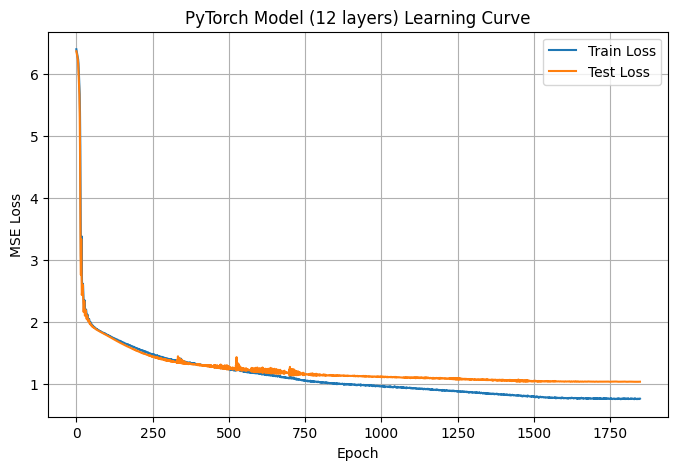

[PyTorch Model (12 layers) - Test Set]
MAE:  0.7452
RMSE: 1.0189
R²:   0.5699

[PyTorch Model (12 layers) - Training Set]
MAE:  0.5767
RMSE: 0.7576
R²:   0.7627


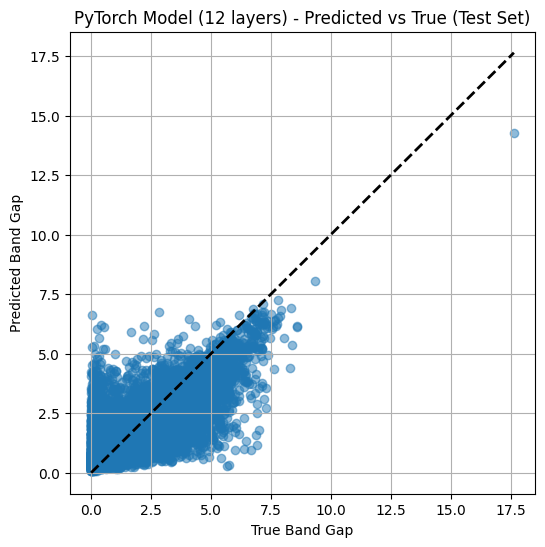

In [ ]:
# Make a metrics dictionary
model_layers12_metrics = evaluate_model(
    model_layers12,
    X_train_tensor,
    y_train,
    X_test_tensor,
    y_test
)
# Analyze the model
analyze_model(
    model_layers12_metrics,
    y_test,
    train_losses_layers12,
    test_losses_layers12,
    model_name="PyTorch Model (12 layers)"
)

In [ ]:
# shape of model_layers12_metrics['test']['y_pred_test']
print(model_layers12_metrics['test']['y_pred_test'].shape)
print(y_test.shape)

(16400, 1)
(16400,)


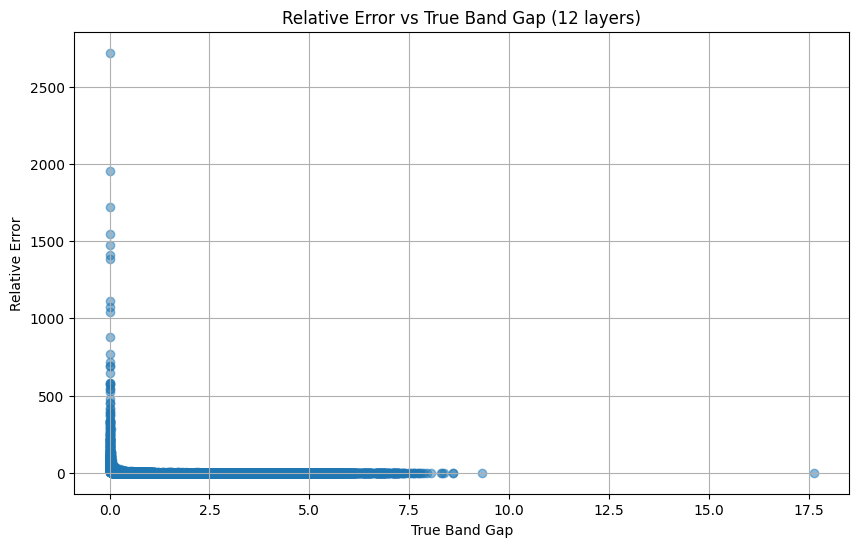

In [ ]:
# relative error vs true band gap plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, np.abs(model_layers12_metrics['test']['y_pred_test'].flatten() - y_test) / y_test, alpha=0.5)
plt.xlabel("True Band Gap")
plt.ylabel("Relative Error")
plt.title("Relative Error vs True Band Gap (12 layers)")
plt.grid(True)
plt.show()

## Ensemble Predictions

In [ ]:
def ensemble_predict(models, X_tensor):
    """
    Averages predictions from multiple models.

    Args:
        models (list): List of trained PyTorch models
        X_tensor (torch.Tensor): Input features

    Returns:
        np.ndarray: Averaged predictions (numpy array)
    """
    preds = []

    for model in models:
        model.eval()
        with torch.no_grad():
            pred = model(X_tensor).detach().cpu().numpy()
            preds.append(pred)

    # Stack and average predictions
    preds = np.stack(preds, axis=0)  # Shape: (num_models, num_samples, 1)
    avg_preds = np.mean(preds, axis=0)  # Shape: (num_samples, 1)

    return avg_preds


In [ ]:
# Assume you have 3 trained models
# models["Random Forest"].fit(X_train_processed, y_train)
models = [model_layers6, model_layers10]

# Ensemble predictions on test data
ensemble_preds = ensemble_predict(models, X_test_tensor)

mae = mean_absolute_error(y_test, ensemble_preds)
rmse = mean_squared_error(y_test, ensemble_preds)
r2 = r2_score(y_test, ensemble_preds)

print(f"[Ensemble Results models 6 and 10 layers]")
print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²:   {r2:.4f}")

[Ensemble Results models 6 and 10 layers]
MAE:  0.7234
RMSE: 0.9629
R²:   0.6011


### Less Layers but more iterations?

In [ ]:
# residuals = y_test - y_pred_torch.flatten()

# plt.figure(figsize=(8, 6))
# sns.scatterplot(x=y_pred_torch.flatten(), y=residuals)
# plt.axhline(0, linestyle='--', color='red')
# plt.xlabel('Predicted')
# plt.ylabel('Residuals')
# plt.title('Residuals vs. Predicted')
# plt.grid(True)
# plt.show()


In [ ]:
# plt.figure(figsize=(8, 6))
# sns.histplot(residuals, kde=True)
# plt.title('Distribution of Residuals')
# plt.xlabel('Residual')
# plt.grid(True)
# plt.show()


#### Posibly Add Weight Initialization

In [ ]:
# def init_weights(m):
#     if isinstance(m, nn.Linear):
#         nn.init.kaiming_normal_(m.weight)
#         if m.bias is not None:
#             nn.init.zeros_(m.bias)

# model2.apply(init_weights)

In [ ]:
# Print the summaries of all the models based on mae rmse and r2#
# Use also the metrics from the above models

# Summary of all

In [ ]:
# Print the summaries of all the models based on mae rmse and r2#
# summarize all model by mae and r2 values
print("\nSummary of all models: band gap range 0.001 - 50 eV")
print(f"{'Model':<30} {'MAE':<10} {'RMSE':<10} {'R²':<10}")
for name, result in results.items():
    print(f"{name:<30} {result['mae']:<10.4f} {np.sqrt(result['mae']):<10.4f} {result['r2']:<10.4f}")
print(f"{'PyTorch 3-layers':<30} {model_layers3_metrics['test']['MAE']:<10.4f} {model_layers3_metrics['test']['RMSE']:<10.4f} {model_layers3_metrics['test']['R2']:<10.4f}")
# print(f"{'PyTorch 3-layers train':<30} {model_layers3_metrics['train']['MAE']:<10.4f} {model_layers3_metrics['train']['RMSE']:<10.4f} {model_layers3_metrics['train']['R2']:<10.4f}")
print(f"{'PyTorch 6-layers':<30} {model_layers6_metrics['test']['MAE']:<10.4f} {model_layers6_metrics['test']['RMSE']:<10.4f} {model_layers6_metrics['test']['R2']:<10.4f}")
# print(f"{'PyTorch 6-layers train':<30} {model_layers6_metrics['train']['MAE']:<10.4f} {model_layers6_metrics['train']['RMSE']:<10.4f} {model_layers6_metrics['train']['R2']:<10.4f}")
print(f"{'PyTorch 10-layers':<30} {model_layers10_metrics['test']['MAE']:<10.4f} {model_layers10_metrics['test']['RMSE']:<10.4f} {model_layers10_metrics['test']['R2']:<10.4f}")
# print(f"{'PyTorch 10-layers train':<30} {model_layers10_metrics['train']['MAE']:<10.4f} {model_layers10_metrics['train']['RMSE']:<10.4f} {model_layers10_metrics['train']['R2']:<10.4f}")
print(f"{'PyTorch 12-layers':<30} {model_layers12_metrics['test']['MAE']:<10.4f} {model_layers12_metrics['test']['RMSE']:<10.4f} {model_layers12_metrics['test']['R2']:<10.4f}")
print(f"{'Ensemble 6 and 10 layers':<30} {mae:<10.4f} {rmse:<10.4f} {r2:<10.4f}")


Summary of all models: band gap range 0.001 - 50 eV
Model                          MAE        RMSE       R²        
Dummy                          1.2696     1.1268     -0.0000   
Linear Regression              1.0906     1.0443     0.2239    
Ridge Regression               1.0906     1.0443     0.2239    
Gradient Boosting              0.9227     0.9606     0.4332    
XGBoost                        0.9245     0.9615     0.4314    
Hist Gradient Boosting         0.9200     0.9592     0.4350    
Random Forest                  0.6895     0.8304     0.6340    
PyTorch 3-layers               0.8395     1.1146     0.4854    
PyTorch 6-layers               0.7517     1.0106     0.5769    
PyTorch 10-layers              0.7232     1.0013     0.5846    
PyTorch 12-layers              0.7452     1.0189     0.5699    
Ensemble 6 and 10 layers       0.7234     0.9629     0.6011    


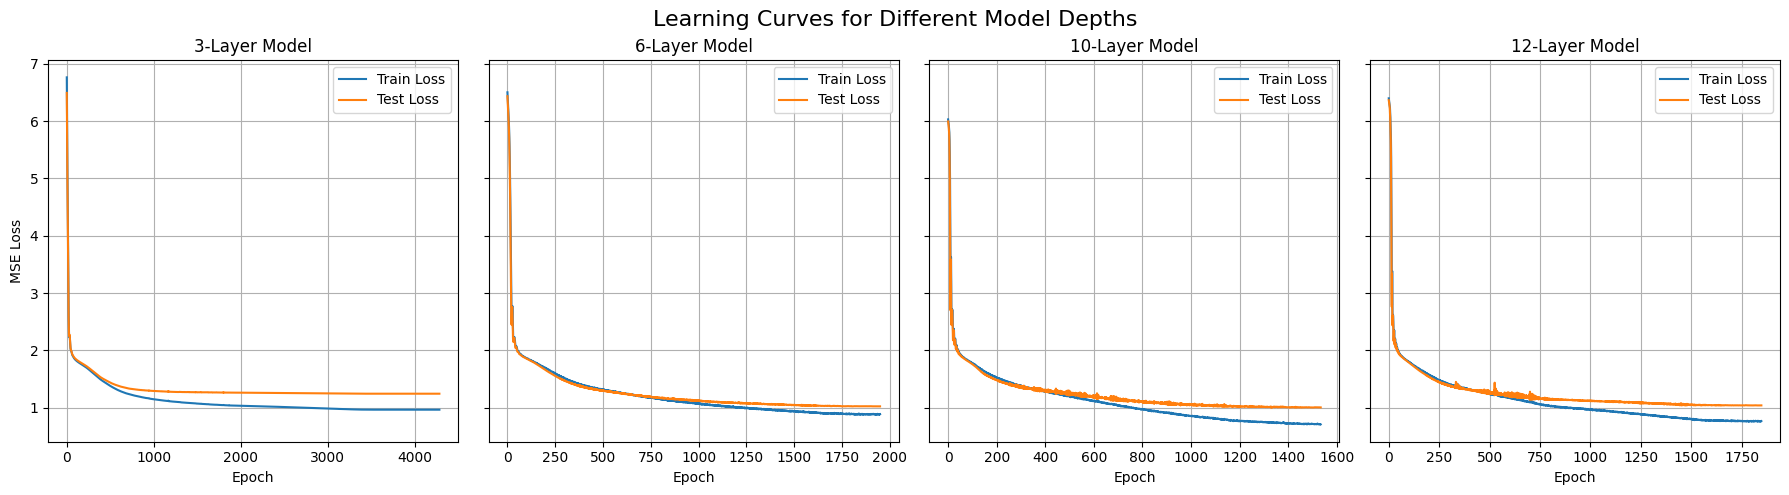

In [ ]:

import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 4, figsize=(18, 5), sharey=True)

# Model: 3 Layers
axes[0].plot(train_losses_layers3, label="Train Loss")
axes[0].plot(test_losses_layers3, label="Test Loss")
axes[0].set_title("3-Layer Model")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("MSE Loss")
axes[0].legend()
axes[0].grid(True)

# Model: 6 Layers
axes[1].plot(train_losses_layers6, label="Train Loss")
axes[1].plot(test_losses_layers6, label="Test Loss")
axes[1].set_title("6-Layer Model")
axes[1].set_xlabel("Epoch")
axes[1].legend()
axes[1].grid(True)

# Model: 10 Layers
axes[2].plot(train_losses_layers10, label="Train Loss")
axes[2].plot(test_losses_layers10, label="Test Loss")
axes[2].set_title("10-Layer Model")
axes[2].set_xlabel("Epoch")
axes[2].legend()
axes[2].grid(True)

# Model: 12 Layers
axes[3].plot(train_losses_layers12, label="Train Loss")
axes[3].plot(test_losses_layers12, label="Test Loss")
axes[3].set_title("12-Layer Model")
axes[3].set_xlabel("Epoch")
axes[3].legend()
axes[3].grid(True)


# Set overall title
fig.suptitle("Learning Curves for Different Model Depths", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()



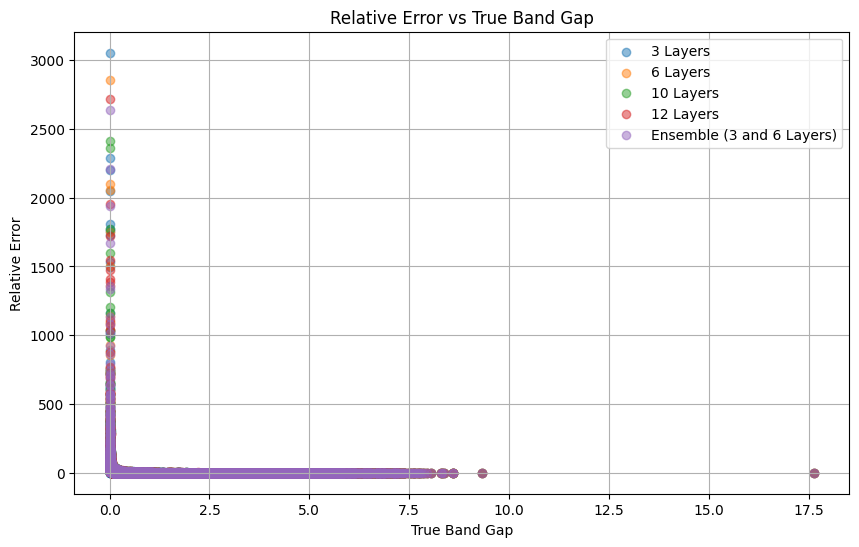

In [ ]:
# relative error vs true band gap for 3 6 10 and 12 layers
plt.figure(figsize=(10, 6))
plt.scatter(y_test, np.abs(model_layers3_metrics['test']['y_pred_test'].flatten() - y_test) / y_test, alpha=0.5, label="3 Layers")
plt.scatter(y_test, np.abs(model_layers6_metrics['test']['y_pred_test'].flatten() - y_test) / y_test, alpha=0.5, label="6 Layers")
plt.scatter(y_test, np.abs(model_layers10_metrics['test']['y_pred_test'].flatten() - y_test) / y_test, alpha=0.5, label="10 Layers")
plt.scatter(y_test, np.abs(model_layers12_metrics['test']['y_pred_test'].flatten() - y_test) / y_test, alpha=0.5, label="12 Layers")
plt.scatter(y_test, np.abs(ensemble_preds.flatten() - y_test) / y_test, alpha=0.5, label="Ensemble (3 and 6 Layers)")
plt.xlabel("True Band Gap")
plt.ylabel("Relative Error")
plt.title("Relative Error vs True Band Gap")
plt.legend()
plt.grid(True)
plt.show()